In [1]:
import pandas as pd
from pearlsim.ml_utilities import *
import os
import random
import numpy as np
from pearlsim.results_processing import read_res_file
from scipy.interpolate import pchip_interpolate, griddata, interp1d

2024-03-03 17:01:04.057161: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 17:01:04.115374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-03 17:01:04.116470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 17:01:06.073381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
current_data = pd.read_csv("training_data/current_target.csv", index_col=0)
raw_concentration_data = pd.read_csv("training_data/current_data.csv", index_col=0).fillna(0.0)
concentration_data = raw_concentration_data.drop(columns=["local_fima", "local_graphite_frac", "E1_flux_interpolated", "E2_flux_interpolated", "E3_flux_interpolated", 
                                                          "E4_flux_interpolated", "E5_flux_interpolated", "E6_flux_interpolated", "E7_flux_interpolated", "E8_flux_interpolated", 
                                                          "E9_flux_interpolated", "E10_flux_interpolated", "E11_flux_interpolated", "E12_flux_interpolated", "E13_flux_interpolated", 
                                                          "E14_flux_interpolated", "E15_flux_interpolated", "E16_flux_interpolated", "E17_flux_interpolated", "E18_flux_interpolated", 
                                                          "radius", "power_interpolated", "height", "step"])

In [3]:
def gen_source_distribution(surface_current, num_bins=200, show_current=False):
    current_bin_widths = np.diff(ENERGY_BINS)
    surface_current = surface_current/current_bin_widths
    log_energy_centers = (np.log(ENERGY_BINS[1:]) + np.log(ENERGY_BINS[:-1])) / 2
    
    new_grid = np.linspace(np.log(ENERGY_BINS[0]) , np.log(ENERGY_BINS[-1]), num_bins)
    new_midpoints = (new_grid[1:] + new_grid[:-1]) / 2
    
    
    interpolator = interp1d(log_energy_centers, np.log(surface_current), fill_value="extrapolate")
    interpolated_current = np.exp(interpolator(new_midpoints))
    
    energy_bins = np.exp(new_grid)
    weights = [0] + list(interpolated_current)
    if show_current:
        plt.figure()
        plt.stairs(surface_current, ENERGY_BINS)
        plt.plot(np.exp(log_energy_centers), surface_current, ".")
        plt.plot(np.exp(new_midpoints), interpolated_current)
        plt.yscale("log")
        plt.xscale("log")
        plt.show()
    return energy_bins, weights

def generate_pebble_model(template_path, current_vector, concentrations, temp, days=0,
                            particles=50000000, num_bins=500, show_current=False):
    lib_str = get_cross_section_string(temp)
    surface_current = current_vector.drop(labels=["power"])
    energy_bins, weights = gen_source_distribution(surface_current, num_bins=num_bins,
                                                  show_current=show_current)
    power = current_vector['power']
    total_current = np.sum(surface_current)
    
    
    with open(template_path, "r") as f:
        input_s = f.read()
    concentration_s = ""
    for key in concentrations.keys():
        concentration_s  += f"  {key}    {concentrations[key]}\n".replace("<lib>", lib_str)
    input_s = input_s.replace("<concentrations>", concentration_s)
    input_s = input_s.replace("<temperature>", str(temp))
    


    
    source_str = f"sb {len(weights)} 2\n"
    for i in range(len(weights)):
        source_str += f"  {np.format_float_scientific(energy_bins[i],8)} {np.format_float_scientific(weights[i],8)}\n"
    input_s += f"\n% set power {power}\n"
    input_s += f"\nset srcrate {total_current}\n"
    if days > 0:
        input_s += f"\ndep daystep {days}\n"
    input_s += "set gcu 0 \n \nset mdep 0 3.626338E-01 \n1 fuel  \n10030 2 \n10030 16 \n30060 2 \n30060 24 \n30060 51 \n30060 52 \n30060 53 \n30060 54 \n30060 55 \n30060 56 \n30060 57 \n30060 58 \n30060 59 \n30060 60 \n30060 61 \n30060 62 \n30060 63 \n30060 64 \n30060 65 \n30060 66 \n30060 67 \n30060 68 \n30060 69 \n30060 70 \n30060 71 \n30060 72 \n30060 73 \n30060 74 \n30060 75 \n30060 76 \n30060 77 \n30060 78 \n30060 79 \n30060 80 \n30060 81 \n30060 102 \n30060 103 \n30060 105 \n30060 4 \n30070 2 \n30070 16 \n30070 24 \n30070 25 \n30070 51 \n30070 52 \n30070 53 \n30070 54 \n30070 55 \n30070 56 \n30070 57 \n30070 58 \n30070 59 \n30070 60 \n30070 61 \n30070 62 \n30070 63 \n30070 64 \n30070 65 \n30070 66 \n30070 67 \n30070 68 \n30070 69 \n30070 70 \n30070 71 \n30070 72 \n30070 73 \n30070 74 \n30070 75 \n30070 76 \n30070 77 \n30070 78 \n30070 79 \n30070 80 \n30070 81 \n30070 82 \n30070 102 \n30070 104 \n30070 4 \n50100 2 \n50100 51 \n50100 52 \n50100 53 \n50100 54 \n50100 55 \n50100 56 \n50100 57 \n50100 58 \n50100 59 \n50100 60 \n50100 61 \n50100 62 \n50100 63 \n50100 64 \n50100 65 \n50100 66 \n50100 67 \n50100 68 \n50100 69 \n50100 70 \n50100 71 \n50100 72 \n50100 73 \n50100 74 \n50100 75 \n50100 76 \n50100 77 \n50100 78 \n50100 79 \n50100 80 \n50100 81 \n50100 82 \n50100 83 \n50100 84 \n50100 85 \n50100 102 \n50100 103 \n50100 104 \n50100 107 \n50100 113 \n50100 4 \n50110 2 \n50110 16 \n50110 22 \n50110 28 \n50110 51 \n50110 52 \n50110 53 \n50110 54 \n50110 55 \n50110 56 \n50110 57 \n50110 58 \n50110 59 \n50110 60 \n50110 91 \n50110 102 \n50110 103 \n50110 105 \n50110 107 \n50110 4 \n60120 2 \n60120 51 \n60120 52 \n60120 53 \n60120 54 \n60120 55 \n60120 56 \n60120 57 \n60120 58 \n60120 59 \n60120 60 \n60120 61 \n60120 62 \n60120 63 \n60120 64 \n60120 65 \n60120 66 \n60120 67 \n60120 68 \n60120 69 \n60120 70 \n60120 71 \n60120 72 \n60120 73 \n60120 74 \n60120 75 \n60120 91 \n60120 102 \n60120 103 \n60120 104 \n60120 107 \n60120 4 \n80160 2 \n80160 16 \n80160 22 \n80160 23 \n80160 28 \n80160 51 \n80160 52 \n80160 53 \n80160 54 \n80160 55 \n80160 56 \n80160 57 \n80160 91 \n80160 102 \n80160 103 \n80160 104 \n80160 105 \n80160 107 \n80160 108 \n80160 4 \n340740 2 \n340740 16 \n340740 22 \n340740 28 \n340740 51 \n340740 52 \n340740 53 \n340740 54 \n340740 55 \n340740 91 \n340740 102 \n340740 103 \n340740 104 \n340740 105 \n340740 106 \n340740 107 \n340740 111 \n340740 4 \n340800 2 \n340800 16 \n340800 17 \n340800 22 \n340800 28 \n340800 51 \n340800 52 \n340800 53 \n340800 54 \n340800 55 \n340800 56 \n340800 57 \n340800 58 \n340800 59 \n340800 60 \n340800 61 \n340800 62 \n340800 63 \n340800 64 \n340800 65 \n340800 66 \n340800 67 \n340800 68 \n340800 69 \n340800 70 \n340800 71 \n340800 72 \n340800 73 \n340800 74 \n340800 75 \n340800 76 \n340800 77 \n340800 78 \n340800 79 \n340800 91 \n340800 102 \n340800 103 \n340800 104 \n340800 105 \n340800 107 \n340800 4 \n340800 102m \n340820 2 \n340820 16 \n340820 17 \n340820 22 \n340820 28 \n340820 51 \n340820 52 \n340820 53 \n340820 54 \n340820 55 \n340820 56 \n340820 91 \n340820 102 \n340820 103 \n340820 104 \n340820 105 \n340820 107 \n340820 4 \n340820 102m \n350810 2 \n350810 16 \n350810 17 \n350810 22 \n350810 28 \n350810 32 \n350810 33 \n350810 51 \n350810 52 \n350810 53 \n350810 54 \n350810 55 \n350810 56 \n350810 57 \n350810 58 \n350810 59 \n350810 60 \n350810 61 \n350810 62 \n350810 63 \n350810 64 \n350810 65 \n350810 66 \n350810 67 \n350810 68 \n350810 69 \n350810 70 \n350810 71 \n350810 72 \n350810 73 \n350810 74 \n350810 75 \n350810 76 \n350810 91 \n350810 102 \n350810 103 \n350810 104 \n350810 105 \n350810 107 \n350810 4 \n350810 102m \n360800 2 \n360800 16 \n360800 22 \n360800 28 \n360800 51 \n360800 52 \n360800 53 \n360800 54 \n360800 55 \n360800 56 \n360800 57 \n360800 58 \n360800 59 \n360800 60 \n360800 61 \n360800 62 \n360800 63 \n360800 64 \n360800 65 \n360800 66 \n360800 67 \n360800 68 \n360800 69 \n360800 70 \n360800 71 \n360800 72 \n360800 73 \n360800 74 \n360800 75 \n360800 76 \n360800 77 \n360800 78 \n360800 79 \n360800 91 \n360800 102 \n360800 103 \n360800 104 \n360800 105 \n360800 106 \n360800 107 \n360800 111 \n360800 4 \n360800 102m \n360820 2 \n360820 16 \n360820 17 \n360820 22 \n360820 28 \n360820 51 \n360820 52 \n360820 53 \n360820 54 \n360820 55 \n360820 56 \n360820 57 \n360820 58 \n360820 59 \n360820 60 \n360820 61 \n360820 62 \n360820 63 \n360820 64 \n360820 91 \n360820 102 \n360820 103 \n360820 104 \n360820 105 \n360820 107 \n360820 4 \n360820 102m \n360830 2 \n360830 16 \n360830 17 \n360830 22 \n360830 28 \n360830 51 \n360830 52 \n360830 53 \n360830 54 \n360830 55 \n360830 56 \n360830 57 \n360830 58 \n360830 59 \n360830 60 \n360830 61 \n360830 62 \n360830 63 \n360830 64 \n360830 65 \n360830 91 \n360830 102 \n360830 103 \n360830 104 \n360830 105 \n360830 106 \n360830 107 \n360830 111 \n360830 4 \n360840 2 \n360840 16 \n360840 17 \n360840 22 \n360840 28 \n360840 51 \n360840 52 \n360840 53 \n360840 54 \n360840 55 \n360840 56 \n360840 57 \n360840 58 \n360840 59 \n360840 60 \n360840 61 \n360840 62 \n360840 63 \n360840 64 \n360840 65 \n360840 66 \n360840 91 \n360840 102 \n360840 103 \n360840 104 \n360840 105 \n360840 107 \n360840 4 \n360840 102m \n360850 2 \n360850 16 \n360850 17 \n360850 22 \n360850 24 \n360850 28 \n360850 41 \n360850 51 \n360850 52 \n360850 53 \n360850 54 \n360850 55 \n360850 56 \n360850 57 \n360850 91 \n360850 102 \n360850 103 \n360850 107 \n360850 4 \n360860 2 \n360860 16 \n360860 17 \n360860 22 \n360860 28 \n360860 51 \n360860 52 \n360860 53 \n360860 54 \n360860 55 \n360860 56 \n360860 57 \n360860 58 \n360860 59 \n360860 60 \n360860 91 \n360860 102 \n360860 103 \n360860 104 \n360860 105 \n360860 107 \n360860 4 \n370850 2 \n370850 16 \n370850 17 \n370850 22 \n370850 28 \n370850 32 \n370850 51 \n370850 52 \n370850 53 \n370850 54 \n370850 55 \n370850 56 \n370850 57 \n370850 58 \n370850 91 \n370850 102 \n370850 103 \n370850 104 \n370850 105 \n370850 106 \n370850 107 \n370850 4 \n370850 102m \n370860 2 \n370860 16 \n370860 17 \n370860 22 \n370860 24 \n370860 28 \n370860 41 \n370860 51 \n370860 52 \n370860 53 \n370860 54 \n370860 55 \n370860 56 \n370860 57 \n370860 58 \n370860 59 \n370860 60 \n370860 61 \n370860 91 \n370860 102 \n370860 103 \n370860 107 \n370860 4 \n370870 2 \n370870 16 \n370870 17 \n370870 22 \n370870 28 \n370870 32 \n370870 51 \n370870 52 \n370870 53 \n370870 54 \n370870 55 \n370870 56 \n370870 57 \n370870 91 \n370870 102 \n370870 103 \n370870 104 \n370870 105 \n370870 107 \n370870 4 \n380840 2 \n380840 16 \n380840 22 \n380840 28 \n380840 51 \n380840 52 \n380840 53 \n380840 54 \n380840 55 \n380840 56 \n380840 57 \n380840 58 \n380840 59 \n380840 91 \n380840 102 \n380840 103 \n380840 107 \n380840 4 \n380840 102m \n380860 2 \n380860 16 \n380860 22 \n380860 28 \n380860 51 \n380860 52 \n380860 53 \n380860 54 \n380860 55 \n380860 56 \n380860 57 \n380860 58 \n380860 59 \n380860 60 \n380860 61 \n380860 62 \n380860 63 \n380860 91 \n380860 102 \n380860 103 \n380860 104 \n380860 105 \n380860 107 \n380860 111 \n380860 4 \n380860 102m \n380870 2 \n380870 16 \n380870 22 \n380870 28 \n380870 32 \n380870 51 \n380870 52 \n380870 53 \n380870 54 \n380870 55 \n380870 56 \n380870 57 \n380870 91 \n380870 102 \n380870 103 \n380870 104 \n380870 105 \n380870 106 \n380870 107 \n380870 4 \n380880 2 \n380880 16 \n380880 17 \n380880 22 \n380880 28 \n380880 51 \n380880 52 \n380880 53 \n380880 54 \n380880 55 \n380880 56 \n380880 57 \n380880 58 \n380880 59 \n380880 60 \n380880 61 \n380880 62 \n380880 63 \n380880 64 \n380880 65 \n380880 66 \n380880 67 \n380880 68 \n380880 69 \n380880 70 \n380880 71 \n380880 72 \n380880 91 \n380880 102 \n380880 103 \n380880 104 \n380880 105 \n380880 106 \n380880 107 \n380880 4 \n380890 2 \n380890 16 \n380890 17 \n380890 22 \n380890 28 \n380890 51 \n380890 52 \n380890 53 \n380890 54 \n380890 55 \n380890 56 \n380890 57 \n380890 58 \n380890 59 \n380890 60 \n380890 61 \n380890 62 \n380890 63 \n380890 64 \n380890 65 \n380890 66 \n380890 67 \n380890 91 \n380890 102 \n380890 103 \n380890 104 \n380890 105 \n380890 106 \n380890 107 \n380890 4 \n380900 2 \n380900 16 \n380900 17 \n380900 22 \n380900 28 \n380900 32 \n380900 51 \n380900 52 \n380900 53 \n380900 54 \n380900 55 \n380900 91 \n380900 102 \n380900 103 \n380900 104 \n380900 105 \n380900 107 \n380900 4 \n390890 2 \n390890 16 \n390890 22 \n390890 28 \n390890 51 \n390890 52 \n390890 53 \n390890 54 \n390890 55 \n390890 56 \n390890 57 \n390890 58 \n390890 59 \n390890 60 \n390890 61 \n390890 62 \n390890 91 \n390890 102 \n390890 103 \n390890 104 \n390890 105 \n390890 106 \n390890 107 \n390890 4 \n390890 102m \n390900 2 \n390900 16 \n390900 17 \n390900 22 \n390900 24 \n390900 28 \n390900 41 \n390900 51 \n390900 52 \n390900 53 \n390900 54 \n390900 55 \n390900 56 \n390900 57 \n390900 58 \n390900 59 \n390900 91 \n390900 102 \n390900 4 \n390900 102m \n390910 2 \n390910 16 \n390910 17 \n390910 22 \n390910 28 \n390910 32 \n390910 33 \n390910 51 \n390910 52 \n390910 53 \n390910 54 \n390910 55 \n390910 56 \n390910 57 \n390910 58 \n390910 59 \n390910 60 \n390910 61 \n390910 62 \n390910 63 \n390910 64 \n390910 65 \n390910 66 \n390910 67 \n390910 68 \n390910 69 \n390910 70 \n390910 71 \n390910 72 \n390910 73 \n390910 74 \n390910 75 \n390910 76 \n390910 77 \n390910 78 \n390910 79 \n390910 91 \n390910 102 \n390910 103 \n390910 104 \n390910 105 \n390910 107 \n390910 4 \n400900 2 \n400900 16 \n400900 22 \n400900 28 \n400900 51 \n400900 52 \n400900 53 \n400900 54 \n400900 55 \n400900 56 \n400900 57 \n400900 58 \n400900 59 \n400900 60 \n400900 91 \n400900 102 \n400900 103 \n400900 107 \n400900 4 \n400910 2 \n400910 16 \n400910 17 \n400910 22 \n400910 28 \n400910 32 \n400910 51 \n400910 52 \n400910 53 \n400910 54 \n400910 55 \n400910 56 \n400910 57 \n400910 58 \n400910 59 \n400910 60 \n400910 61 \n400910 62 \n400910 63 \n400910 64 \n400910 91 \n400910 102 \n400910 103 \n400910 104 \n400910 105 \n400910 106 \n400910 107 \n400910 4 \n400920 2 \n400920 16 \n400920 17 \n400920 22 \n400920 28 \n400920 32 \n400920 33 \n400920 51 \n400920 52 \n400920 53 \n400920 54 \n400920 55 \n400920 56 \n400920 57 \n400920 58 \n400920 59 \n400920 60 \n400920 61 \n400920 62 \n400920 63 \n400920 64 \n400920 65 \n400920 66 \n400920 67 \n400920 91 \n400920 102 \n400920 103 \n400920 104 \n400920 105 \n400920 107 \n400920 4 \n400930 2 \n400930 16 \n400930 17 \n400930 22 \n400930 28 \n400930 32 \n400930 33 \n400930 51 \n400930 52 \n400930 53 \n400930 54 \n400930 55 \n400930 56 \n400930 57 \n400930 58 \n400930 59 \n400930 60 \n400930 91 \n400930 102 \n400930 103 \n400930 104 \n400930 105 \n400930 107 \n400930 4 \n400940 2 \n400940 16 \n400940 17 \n400940 22 \n400940 28 \n400940 32 \n400940 51 \n400940 52 \n400940 53 \n400940 54 \n400940 55 \n400940 56 \n400940 57 \n400940 58 \n400940 59 \n400940 60 \n400940 61 \n400940 62 \n400940 63 \n400940 64 \n400940 91 \n400940 102 \n400940 103 \n400940 104 \n400940 105 \n400940 107 \n400940 4 \n400950 2 \n400950 16 \n400950 17 \n400950 22 \n400950 28 \n400950 32 \n400950 51 \n400950 52 \n400950 53 \n400950 54 \n400950 55 \n400950 56 \n400950 57 \n400950 58 \n400950 59 \n400950 60 \n400950 61 \n400950 62 \n400950 63 \n400950 64 \n400950 65 \n400950 66 \n400950 67 \n400950 68 \n400950 69 \n400950 70 \n400950 71 \n400950 72 \n400950 73 \n400950 91 \n400950 102 \n400950 103 \n400950 104 \n400950 105 \n400950 107 \n400950 4 \n400960 2 \n400960 16 \n400960 17 \n400960 22 \n400960 28 \n400960 51 \n400960 52 \n400960 53 \n400960 54 \n400960 55 \n400960 56 \n400960 57 \n400960 91 \n400960 102 \n400960 103 \n400960 104 \n400960 105 \n400960 107 \n400960 4 \n410930 2 \n410930 16 \n410930 17 \n410930 22 \n410930 28 \n410930 32 \n410930 33 \n410930 51 \n410930 52 \n410930 53 \n410930 54 \n410930 55 \n410930 56 \n410930 57 \n410930 58 \n410930 59 \n410930 60 \n410930 61 \n410930 62 \n410930 63 \n410930 64 \n410930 65 \n410930 66 \n410930 67 \n410930 68 \n410930 69 \n410930 70 \n410930 71 \n410930 72 \n410930 73 \n410930 91 \n410930 102 \n410930 103 \n410930 104 \n410930 105 \n410930 107 \n410930 4 \n410930 102m \n410940 2 \n410940 16 \n410940 17 \n410940 22 \n410940 28 \n410940 32 \n410940 33 \n410940 51 \n410940 52 \n410940 53 \n410940 54 \n410940 55 \n410940 56 \n410940 57 \n410940 58 \n410940 59 \n410940 60 \n410940 61 \n410940 62 \n410940 63 \n410940 64 \n410940 65 \n410940 66 \n410940 67 \n410940 68 \n410940 69 \n410940 70 \n410940 71 \n410940 72 \n410940 73 \n410940 74 \n410940 75 \n410940 76 \n410940 77 \n410940 78 \n410940 79 \n410940 91 \n410940 102 \n410940 103 \n410940 104 \n410940 105 \n410940 106 \n410940 107 \n410940 4 \n410940 102m \n410950 2 \n410950 16 \n410950 17 \n410950 22 \n410950 28 \n410950 32 \n410950 33 \n410950 51 \n410950 52 \n410950 53 \n410950 54 \n410950 55 \n410950 56 \n410950 57 \n410950 58 \n410950 59 \n410950 60 \n410950 61 \n410950 62 \n410950 63 \n410950 64 \n410950 65 \n410950 66 \n410950 67 \n410950 68 \n410950 69 \n410950 70 \n410950 91 \n410950 102 \n410950 103 \n410950 104 \n410950 105 \n410950 106 \n410950 107 \n410950 4 \n420920 2 \n420920 16 \n420920 22 \n420920 28 \n420920 51 \n420920 52 \n420920 53 \n420920 54 \n420920 55 \n420920 56 \n420920 57 \n420920 58 \n420920 59 \n420920 60 \n420920 61 \n420920 62 \n420920 63 \n420920 64 \n420920 65 \n420920 66 \n420920 91 \n420920 102 \n420920 103 \n420920 104 \n420920 105 \n420920 106 \n420920 107 \n420920 111 \n420920 4 \n420920 102m \n420940 2 \n420940 16 \n420940 17 \n420940 22 \n420940 28 \n420940 51 \n420940 52 \n420940 53 \n420940 54 \n420940 55 \n420940 56 \n420940 57 \n420940 58 \n420940 59 \n420940 60 \n420940 61 \n420940 62 \n420940 63 \n420940 64 \n420940 65 \n420940 66 \n420940 67 \n420940 68 \n420940 69 \n420940 91 \n420940 102 \n420940 103 \n420940 104 \n420940 105 \n420940 106 \n420940 107 \n420940 111 \n420940 4 \n420950 2 \n420950 16 \n420950 17 \n420950 22 \n420950 24 \n420950 28 \n420950 41 \n420950 51 \n420950 52 \n420950 53 \n420950 54 \n420950 55 \n420950 56 \n420950 57 \n420950 58 \n420950 59 \n420950 60 \n420950 61 \n420950 62 \n420950 63 \n420950 64 \n420950 65 \n420950 66 \n420950 67 \n420950 68 \n420950 69 \n420950 70 \n420950 71 \n420950 72 \n420950 73 \n420950 74 \n420950 75 \n420950 76 \n420950 77 \n420950 78 \n420950 91 \n420950 102 \n420950 103 \n420950 107 \n420950 4 \n420960 2 \n420960 16 \n420960 17 \n420960 22 \n420960 28 \n420960 51 \n420960 52 \n420960 53 \n420960 54 \n420960 55 \n420960 56 \n420960 57 \n420960 58 \n420960 59 \n420960 60 \n420960 61 \n420960 62 \n420960 63 \n420960 64 \n420960 65 \n420960 66 \n420960 67 \n420960 91 \n420960 102 \n420960 103 \n420960 104 \n420960 105 \n420960 107 \n420960 4 \n420970 2 \n420970 16 \n420970 17 \n420970 22 \n420970 28 \n420970 51 \n420970 52 \n420970 53 \n420970 54 \n420970 55 \n420970 56 \n420970 57 \n420970 58 \n420970 59 \n420970 60 \n420970 61 \n420970 62 \n420970 63 \n420970 91 \n420970 102 \n420970 103 \n420970 104 \n420970 105 \n420970 106 \n420970 107 \n420970 4 \n420980 2 \n420980 16 \n420980 17 \n420980 22 \n420980 28 \n420980 51 \n420980 52 \n420980 53 \n420980 54 \n420980 55 \n420980 56 \n420980 57 \n420980 58 \n420980 59 \n420980 60 \n420980 61 \n420980 62 \n420980 63 \n420980 64 \n420980 91 \n420980 102 \n420980 103 \n420980 104 \n420980 105 \n420980 107 \n420980 4 \n420990 2 \n420990 16 \n420990 17 \n420990 22 \n420990 28 \n420990 32 \n420990 33 \n420990 51 \n420990 52 \n420990 53 \n420990 54 \n420990 55 \n420990 56 \n420990 57 \n420990 58 \n420990 59 \n420990 60 \n420990 61 \n420990 62 \n420990 63 \n420990 64 \n420990 65 \n420990 66 \n420990 91 \n420990 102 \n420990 103 \n420990 104 \n420990 105 \n420990 107 \n420990 4 \n421000 2 \n421000 16 \n421000 17 \n421000 22 \n421000 28 \n421000 51 \n421000 52 \n421000 53 \n421000 54 \n421000 55 \n421000 56 \n421000 57 \n421000 91 \n421000 102 \n421000 103 \n421000 104 \n421000 105 \n421000 107 \n421000 4 \n430990 2 \n430990 16 \n430990 17 \n430990 22 \n430990 24 \n430990 28 \n430990 41 \n430990 51 \n430990 52 \n430990 53 \n430990 54 \n430990 55 \n430990 56 \n430990 57 \n430990 58 \n430990 59 \n430990 60 \n430990 61 \n430990 62 \n430990 63 \n430990 64 \n430990 65 \n430990 66 \n430990 67 \n430990 68 \n430990 69 \n430990 70 \n430990 71 \n430990 72 \n430990 73 \n430990 74 \n430990 75 \n430990 76 \n430990 77 \n430990 91 \n430990 102 \n430990 103 \n430990 107 \n430990 4 \n440960 2 \n440960 16 \n440960 22 \n440960 28 \n440960 32 \n440960 51 \n440960 52 \n440960 53 \n440960 54 \n440960 55 \n440960 56 \n440960 57 \n440960 58 \n440960 59 \n440960 60 \n440960 61 \n440960 62 \n440960 63 \n440960 91 \n440960 102 \n440960 103 \n440960 104 \n440960 105 \n440960 106 \n440960 107 \n440960 111 \n440960 4 \n440980 2 \n440980 16 \n440980 17 \n440980 22 \n440980 28 \n440980 32 \n440980 51 \n440980 52 \n440980 53 \n440980 54 \n440980 55 \n440980 56 \n440980 57 \n440980 58 \n440980 59 \n440980 60 \n440980 61 \n440980 62 \n440980 63 \n440980 91 \n440980 102 \n440980 103 \n440980 104 \n440980 105 \n440980 106 \n440980 107 \n440980 111 \n440980 4 \n440990 2 \n440990 16 \n440990 17 \n440990 22 \n440990 28 \n440990 32 \n440990 51 \n440990 52 \n440990 53 \n440990 54 \n440990 55 \n440990 56 \n440990 57 \n440990 58 \n440990 59 \n440990 60 \n440990 61 \n440990 62 \n440990 91 \n440990 102 \n440990 103 \n440990 104 \n440990 105 \n440990 106 \n440990 107 \n440990 4 \n441000 2 \n441000 16 \n441000 17 \n441000 22 \n441000 28 \n441000 32 \n441000 51 \n441000 52 \n441000 53 \n441000 54 \n441000 55 \n441000 56 \n441000 57 \n441000 58 \n441000 59 \n441000 60 \n441000 61 \n441000 62 \n441000 63 \n441000 64 \n441000 65 \n441000 66 \n441000 91 \n441000 102 \n441000 103 \n441000 104 \n441000 105 \n441000 107 \n441000 4 \n441010 2 \n441010 16 \n441010 17 \n441010 22 \n441010 24 \n441010 28 \n441010 41 \n441010 51 \n441010 52 \n441010 53 \n441010 54 \n441010 55 \n441010 56 \n441010 57 \n441010 58 \n441010 59 \n441010 60 \n441010 61 \n441010 62 \n441010 63 \n441010 64 \n441010 65 \n441010 66 \n441010 67 \n441010 68 \n441010 69 \n441010 91 \n441010 102 \n441010 103 \n441010 107 \n441010 4 \n441020 2 \n441020 16 \n441020 17 \n441020 22 \n441020 28 \n441020 51 \n441020 52 \n441020 53 \n441020 54 \n441020 55 \n441020 56 \n441020 91 \n441020 102 \n441020 103 \n441020 104 \n441020 105 \n441020 106 \n441020 107 \n441020 4 \n441030 2 \n441030 16 \n441030 17 \n441030 22 \n441030 28 \n441030 51 \n441030 52 \n441030 53 \n441030 54 \n441030 55 \n441030 56 \n441030 57 \n441030 58 \n441030 59 \n441030 60 \n441030 61 \n441030 62 \n441030 63 \n441030 64 \n441030 65 \n441030 66 \n441030 67 \n441030 68 \n441030 69 \n441030 70 \n441030 71 \n441030 72 \n441030 91 \n441030 102 \n441030 103 \n441030 104 \n441030 105 \n441030 107 \n441030 4 \n441040 2 \n441040 16 \n441040 17 \n441040 22 \n441040 28 \n441040 51 \n441040 52 \n441040 53 \n441040 54 \n441040 55 \n441040 91 \n441040 102 \n441040 103 \n441040 104 \n441040 105 \n441040 107 \n441040 4 \n441050 2 \n441050 16 \n441050 17 \n441050 22 \n441050 28 \n441050 51 \n441050 52 \n441050 53 \n441050 54 \n441050 55 \n441050 56 \n441050 91 \n441050 102 \n441050 103 \n441050 104 \n441050 105 \n441050 107 \n441050 4 \n441060 2 \n441060 16 \n441060 17 \n441060 22 \n441060 28 \n441060 51 \n441060 52 \n441060 53 \n441060 54 \n441060 91 \n441060 102 \n441060 103 \n441060 104 \n441060 105 \n441060 107 \n441060 4 \n451030 2 \n451030 16 \n451030 17 \n451030 22 \n451030 24 \n451030 28 \n451030 41 \n451030 51 \n451030 52 \n451030 53 \n451030 54 \n451030 55 \n451030 56 \n451030 57 \n451030 58 \n451030 59 \n451030 60 \n451030 61 \n451030 62 \n451030 63 \n451030 64 \n451030 65 \n451030 66 \n451030 67 \n451030 68 \n451030 69 \n451030 70 \n451030 71 \n451030 72 \n451030 73 \n451030 74 \n451030 75 \n451030 76 \n451030 77 \n451030 78 \n451030 79 \n451030 80 \n451030 81 \n451030 82 \n451030 83 \n451030 84 \n451030 85 \n451030 86 \n451030 87 \n451030 91 \n451030 102 \n451030 103 \n451030 107 \n451030 4 \n451030 102m \n451050 2 \n451050 16 \n451050 17 \n451050 22 \n451050 28 \n451050 51 \n451050 52 \n451050 53 \n451050 54 \n451050 55 \n451050 56 \n451050 57 \n451050 91 \n451050 102 \n451050 103 \n451050 104 \n451050 105 \n451050 106 \n451050 107 \n451050 4 \n451050 102m \n461020 2 \n461020 16 \n461020 17 \n461020 22 \n461020 24 \n461020 28 \n461020 32 \n461020 41 \n461020 44 \n461020 51 \n461020 52 \n461020 53 \n461020 54 \n461020 55 \n461020 56 \n461020 57 \n461020 58 \n461020 59 \n461020 60 \n461020 61 \n461020 62 \n461020 63 \n461020 64 \n461020 65 \n461020 66 \n461020 67 \n461020 68 \n461020 69 \n461020 91 \n461020 102 \n461020 103 \n461020 104 \n461020 107 \n461020 111 \n461020 4 \n461040 2 \n461040 16 \n461040 17 \n461040 22 \n461040 24 \n461040 28 \n461040 32 \n461040 41 \n461040 51 \n461040 52 \n461040 53 \n461040 54 \n461040 55 \n461040 56 \n461040 57 \n461040 58 \n461040 59 \n461040 60 \n461040 61 \n461040 62 \n461040 63 \n461040 64 \n461040 65 \n461040 66 \n461040 67 \n461040 68 \n461040 69 \n461040 70 \n461040 71 \n461040 72 \n461040 73 \n461040 74 \n461040 91 \n461040 102 \n461040 103 \n461040 104 \n461040 107 \n461040 4 \n461050 2 \n461050 16 \n461050 17 \n461050 22 \n461050 24 \n461050 28 \n461050 41 \n461050 51 \n461050 52 \n461050 53 \n461050 54 \n461050 55 \n461050 56 \n461050 57 \n461050 58 \n461050 59 \n461050 60 \n461050 61 \n461050 62 \n461050 63 \n461050 64 \n461050 65 \n461050 66 \n461050 91 \n461050 102 \n461050 103 \n461050 107 \n461050 4 \n461060 2 \n461060 16 \n461060 17 \n461060 22 \n461060 24 \n461060 28 \n461060 32 \n461060 41 \n461060 51 \n461060 52 \n461060 53 \n461060 54 \n461060 55 \n461060 56 \n461060 57 \n461060 58 \n461060 59 \n461060 60 \n461060 61 \n461060 62 \n461060 63 \n461060 64 \n461060 65 \n461060 66 \n461060 67 \n461060 68 \n461060 69 \n461060 70 \n461060 71 \n461060 72 \n461060 73 \n461060 74 \n461060 91 \n461060 102 \n461060 103 \n461060 104 \n461060 107 \n461060 4 \n461060 102m \n461070 2 \n461070 16 \n461070 17 \n461070 22 \n461070 28 \n461070 32 \n461070 51 \n461070 52 \n461070 53 \n461070 54 \n461070 55 \n461070 56 \n461070 57 \n461070 58 \n461070 59 \n461070 60 \n461070 61 \n461070 62 \n461070 63 \n461070 64 \n461070 65 \n461070 66 \n461070 67 \n461070 68 \n461070 69 \n461070 70 \n461070 91 \n461070 102 \n461070 103 \n461070 104 \n461070 105 \n461070 107 \n461070 4 \n461080 2 \n461080 16 \n461080 17 \n461080 22 \n461080 24 \n461080 28 \n461080 32 \n461080 41 \n461080 51 \n461080 52 \n461080 53 \n461080 54 \n461080 55 \n461080 56 \n461080 57 \n461080 58 \n461080 59 \n461080 60 \n461080 61 \n461080 62 \n461080 63 \n461080 64 \n461080 65 \n461080 66 \n461080 67 \n461080 68 \n461080 69 \n461080 70 \n461080 71 \n461080 72 \n461080 73 \n461080 74 \n461080 91 \n461080 102 \n461080 103 \n461080 104 \n461080 107 \n461080 4 \n461080 102m \n461100 2 \n461100 16 \n461100 17 \n461100 22 \n461100 24 \n461100 28 \n461100 32 \n461100 41 \n461100 51 \n461100 52 \n461100 53 \n461100 54 \n461100 55 \n461100 56 \n461100 57 \n461100 58 \n461100 59 \n461100 60 \n461100 61 \n461100 62 \n461100 63 \n461100 64 \n461100 65 \n461100 66 \n461100 67 \n461100 68 \n461100 69 \n461100 70 \n461100 71 \n461100 72 \n461100 73 \n461100 74 \n461100 91 \n461100 102 \n461100 103 \n461100 104 \n461100 107 \n461100 4 \n461100 102m \n471070 2 \n471070 16 \n471070 51 \n471070 52 \n471070 53 \n471070 54 \n471070 55 \n471070 56 \n471070 91 \n471070 102 \n471070 103 \n471070 104 \n471070 105 \n471070 106 \n471070 107 \n471070 111 \n471070 4 \n471070 102m \n471090 2 \n471090 16 \n471090 17 \n471090 22 \n471090 24 \n471090 28 \n471090 41 \n471090 51 \n471090 52 \n471090 53 \n471090 54 \n471090 55 \n471090 56 \n471090 57 \n471090 58 \n471090 59 \n471090 60 \n471090 61 \n471090 62 \n471090 63 \n471090 64 \n471090 65 \n471090 66 \n471090 67 \n471090 68 \n471090 91 \n471090 102 \n471090 103 \n471090 107 \n471090 4 \n471090 102m \n471101 2 \n471101 16 \n471101 17 \n471101 22 \n471101 28 \n471101 32 \n471101 33 \n471101 51 \n471101 52 \n471101 53 \n471101 54 \n471101 55 \n471101 56 \n471101 57 \n471101 58 \n471101 59 \n471101 60 \n471101 61 \n471101 62 \n471101 63 \n471101 64 \n471101 65 \n471101 66 \n471101 67 \n471101 68 \n471101 69 \n471101 70 \n471101 71 \n471101 72 \n471101 73 \n471101 74 \n471101 75 \n471101 76 \n471101 77 \n471101 78 \n471101 79 \n471101 91 \n471101 102 \n471101 103 \n471101 104 \n471101 105 \n471101 106 \n471101 107 \n471101 4 \n481060 2 \n481060 16 \n481060 17 \n481060 22 \n481060 28 \n481060 32 \n481060 51 \n481060 52 \n481060 53 \n481060 54 \n481060 55 \n481060 56 \n481060 57 \n481060 58 \n481060 59 \n481060 60 \n481060 61 \n481060 91 \n481060 102 \n481060 103 \n481060 104 \n481060 105 \n481060 106 \n481060 107 \n481060 111 \n481060 4 \n481080 2 \n481080 16 \n481080 17 \n481080 22 \n481080 28 \n481080 32 \n481080 33 \n481080 51 \n481080 52 \n481080 53 \n481080 54 \n481080 55 \n481080 56 \n481080 57 \n481080 58 \n481080 59 \n481080 60 \n481080 91 \n481080 102 \n481080 103 \n481080 104 \n481080 105 \n481080 106 \n481080 107 \n481080 4 \n481100 2 \n481100 16 \n481100 17 \n481100 22 \n481100 28 \n481100 32 \n481100 33 \n481100 51 \n481100 52 \n481100 53 \n481100 54 \n481100 55 \n481100 56 \n481100 57 \n481100 58 \n481100 59 \n481100 60 \n481100 61 \n481100 62 \n481100 63 \n481100 64 \n481100 91 \n481100 102 \n481100 103 \n481100 104 \n481100 105 \n481100 106 \n481100 107 \n481100 4 \n481100 102m \n481110 2 \n481110 16 \n481110 17 \n481110 22 \n481110 28 \n481110 32 \n481110 51 \n481110 52 \n481110 53 \n481110 54 \n481110 55 \n481110 56 \n481110 57 \n481110 58 \n481110 59 \n481110 60 \n481110 61 \n481110 91 \n481110 102 \n481110 103 \n481110 104 \n481110 105 \n481110 107 \n481110 4 \n501120 2 \n501120 16 \n501120 17 \n501120 22 \n501120 28 \n501120 51 \n501120 52 \n501120 53 \n501120 54 \n501120 55 \n501120 56 \n501120 57 \n501120 58 \n501120 59 \n501120 60 \n501120 61 \n501120 62 \n501120 63 \n501120 64 \n501120 65 \n501120 66 \n501120 67 \n501120 68 \n501120 69 \n501120 70 \n501120 71 \n501120 72 \n501120 73 \n501120 91 \n501120 102 \n501120 103 \n501120 104 \n501120 105 \n501120 106 \n501120 107 \n501120 111 \n501120 4 \n501120 102m \n501260 2 \n501260 16 \n501260 17 \n501260 22 \n501260 28 \n501260 51 \n501260 52 \n501260 53 \n501260 54 \n501260 55 \n501260 56 \n501260 57 \n501260 91 \n501260 102 \n501260 103 \n501260 104 \n501260 105 \n501260 107 \n501260 4 \n501260 102m \n511240 2 \n511240 16 \n511240 17 \n511240 22 \n511240 28 \n511240 32 \n511240 33 \n511240 51 \n511240 91 \n511240 102 \n511240 103 \n511240 104 \n511240 105 \n511240 107 \n511240 4 \n521300 2 \n521300 16 \n521300 17 \n521300 22 \n521300 28 \n521300 51 \n521300 52 \n521300 53 \n521300 54 \n521300 55 \n521300 56 \n521300 57 \n521300 58 \n521300 59 \n521300 60 \n521300 61 \n521300 62 \n521300 63 \n521300 64 \n521300 65 \n521300 91 \n521300 102 \n521300 103 \n521300 104 \n521300 105 \n521300 107 \n521300 4 \n521300 102m \n521320 2 \n521320 16 \n521320 17 \n521320 22 \n521320 24 \n521320 28 \n521320 51 \n521320 52 \n521320 53 \n521320 54 \n521320 55 \n521320 56 \n521320 57 \n521320 58 \n521320 59 \n521320 60 \n521320 91 \n521320 102 \n521320 103 \n521320 107 \n521320 4 \n521320 102m \n531300 2 \n531300 16 \n531300 17 \n531300 22 \n531300 24 \n531300 28 \n531300 41 \n531300 51 \n531300 52 \n531300 53 \n531300 54 \n531300 55 \n531300 56 \n531300 57 \n531300 91 \n531300 102 \n531300 103 \n531300 107 \n531300 4 \n531310 2 \n531310 16 \n531310 17 \n531310 22 \n531310 28 \n531310 32 \n531310 33 \n531310 51 \n531310 52 \n531310 53 \n531310 54 \n531310 55 \n531310 56 \n531310 57 \n531310 58 \n531310 59 \n531310 60 \n531310 61 \n531310 62 \n531310 63 \n531310 64 \n531310 65 \n531310 91 \n531310 102 \n531310 103 \n531310 104 \n531310 105 \n531310 107 \n531310 4 \n531310 102m \n531350 2 \n531350 16 \n531350 17 \n531350 22 \n531350 28 \n531350 51 \n531350 52 \n531350 91 \n531350 102 \n531350 103 \n531350 104 \n531350 105 \n531350 107 \n531350 4 \n541230 2 \n541230 16 \n541230 17 \n541230 22 \n541230 28 \n541230 51 \n541230 52 \n541230 53 \n541230 54 \n541230 55 \n541230 56 \n541230 57 \n541230 58 \n541230 59 \n541230 60 \n541230 61 \n541230 62 \n541230 63 \n541230 64 \n541230 65 \n541230 66 \n541230 67 \n541230 91 \n541230 102 \n541230 103 \n541230 104 \n541230 105 \n541230 106 \n541230 107 \n541230 111 \n541230 4 \n541240 2 \n541240 16 \n541240 17 \n541240 22 \n541240 28 \n541240 51 \n541240 52 \n541240 53 \n541240 54 \n541240 55 \n541240 56 \n541240 57 \n541240 58 \n541240 59 \n541240 60 \n541240 61 \n541240 62 \n541240 63 \n541240 91 \n541240 102 \n541240 103 \n541240 104 \n541240 105 \n541240 106 \n541240 107 \n541240 111 \n541240 4 \n541240 102m \n541260 2 \n541260 16 \n541260 17 \n541260 22 \n541260 28 \n541260 51 \n541260 52 \n541260 53 \n541260 54 \n541260 55 \n541260 56 \n541260 57 \n541260 58 \n541260 59 \n541260 60 \n541260 61 \n541260 62 \n541260 63 \n541260 64 \n541260 65 \n541260 91 \n541260 102 \n541260 103 \n541260 104 \n541260 105 \n541260 106 \n541260 107 \n541260 4 \n541260 102m \n541300 2 \n541300 16 \n541300 17 \n541300 51 \n541300 52 \n541300 53 \n541300 54 \n541300 55 \n541300 56 \n541300 91 \n541300 102 \n541300 103 \n541300 104 \n541300 105 \n541300 107 \n541300 4 \n541300 102m \n541310 2 \n541310 16 \n541310 17 \n541310 22 \n541310 24 \n541310 28 \n541310 41 \n541310 51 \n541310 52 \n541310 53 \n541310 54 \n541310 55 \n541310 56 \n541310 57 \n541310 58 \n541310 59 \n541310 60 \n541310 61 \n541310 62 \n541310 63 \n541310 64 \n541310 65 \n541310 91 \n541310 102 \n541310 103 \n541310 107 \n541310 4 \n541320 2 \n541320 16 \n541320 17 \n541320 22 \n541320 28 \n541320 51 \n541320 52 \n541320 53 \n541320 54 \n541320 55 \n541320 56 \n541320 57 \n541320 58 \n541320 59 \n541320 60 \n541320 61 \n541320 62 \n541320 63 \n541320 64 \n541320 65 \n541320 66 \n541320 67 \n541320 91 \n541320 102 \n541320 103 \n541320 104 \n541320 105 \n541320 107 \n541320 4 \n541320 102m \n541330 2 \n541330 16 \n541330 17 \n541330 22 \n541330 28 \n541330 32 \n541330 51 \n541330 52 \n541330 53 \n541330 54 \n541330 55 \n541330 56 \n541330 57 \n541330 58 \n541330 59 \n541330 60 \n541330 61 \n541330 62 \n541330 63 \n541330 64 \n541330 91 \n541330 102 \n541330 103 \n541330 104 \n541330 105 \n541330 107 \n541330 4 \n541330 102m \n541340 2 \n541340 16 \n541340 17 \n541340 22 \n541340 28 \n541340 51 \n541340 52 \n541340 53 \n541340 54 \n541340 55 \n541340 56 \n541340 57 \n541340 58 \n541340 59 \n541340 60 \n541340 61 \n541340 62 \n541340 63 \n541340 64 \n541340 65 \n541340 66 \n541340 67 \n541340 68 \n541340 69 \n541340 91 \n541340 102 \n541340 103 \n541340 104 \n541340 105 \n541340 107 \n541340 4 \n541340 102m \n541350 2 \n541350 16 \n541350 17 \n541350 22 \n541350 28 \n541350 32 \n541350 51 \n541350 52 \n541350 53 \n541350 54 \n541350 55 \n541350 56 \n541350 57 \n541350 58 \n541350 59 \n541350 60 \n541350 61 \n541350 62 \n541350 63 \n541350 64 \n541350 65 \n541350 66 \n541350 91 \n541350 102 \n541350 103 \n541350 104 \n541350 105 \n541350 107 \n541350 4 \n541360 2 \n541360 16 \n541360 17 \n541360 22 \n541360 28 \n541360 51 \n541360 52 \n541360 53 \n541360 54 \n541360 55 \n541360 56 \n541360 57 \n541360 58 \n541360 59 \n541360 60 \n541360 61 \n541360 62 \n541360 63 \n541360 64 \n541360 65 \n541360 66 \n541360 91 \n541360 102 \n541360 103 \n541360 104 \n541360 105 \n541360 107 \n541360 4 \n551330 2 \n551330 16 \n551330 17 \n551330 22 \n551330 24 \n551330 28 \n551330 41 \n551330 51 \n551330 52 \n551330 53 \n551330 54 \n551330 55 \n551330 56 \n551330 57 \n551330 58 \n551330 59 \n551330 60 \n551330 61 \n551330 62 \n551330 63 \n551330 64 \n551330 91 \n551330 102 \n551330 103 \n551330 107 \n551330 4 \n551330 102m \n551340 2 \n551340 16 \n551340 17 \n551340 22 \n551340 28 \n551340 32 \n551340 33 \n551340 51 \n551340 52 \n551340 53 \n551340 54 \n551340 55 \n551340 56 \n551340 57 \n551340 58 \n551340 59 \n551340 60 \n551340 61 \n551340 62 \n551340 63 \n551340 64 \n551340 65 \n551340 66 \n551340 67 \n551340 68 \n551340 69 \n551340 70 \n551340 71 \n551340 72 \n551340 73 \n551340 74 \n551340 75 \n551340 76 \n551340 77 \n551340 78 \n551340 79 \n551340 91 \n551340 102 \n551340 103 \n551340 104 \n551340 105 \n551340 106 \n551340 107 \n551340 4 \n551340 102m \n551350 2 \n551350 16 \n551350 17 \n551350 22 \n551350 28 \n551350 32 \n551350 33 \n551350 51 \n551350 52 \n551350 53 \n551350 54 \n551350 91 \n551350 102 \n551350 103 \n551350 104 \n551350 105 \n551350 107 \n551350 4 \n551350 102m \n551360 2 \n551360 16 \n551360 17 \n551360 22 \n551360 28 \n551360 32 \n551360 33 \n551360 91 \n551360 102 \n551360 103 \n551360 104 \n551360 105 \n551360 107 \n551360 4 \n551370 2 \n551370 16 \n551370 17 \n551370 22 \n551370 28 \n551370 32 \n551370 33 \n551370 51 \n551370 52 \n551370 53 \n551370 54 \n551370 55 \n551370 56 \n551370 57 \n551370 91 \n551370 102 \n551370 103 \n551370 104 \n551370 105 \n551370 107 \n551370 4 \n551370 102m \n561300 2 \n561300 16 \n561300 17 \n561300 22 \n561300 28 \n561300 32 \n561300 51 \n561300 52 \n561300 53 \n561300 54 \n561300 55 \n561300 56 \n561300 57 \n561300 91 \n561300 102 \n561300 103 \n561300 104 \n561300 105 \n561300 106 \n561300 107 \n561300 111 \n561300 4 \n561300 102m \n561320 2 \n561320 16 \n561320 17 \n561320 22 \n561320 28 \n561320 51 \n561320 52 \n561320 53 \n561320 54 \n561320 55 \n561320 56 \n561320 57 \n561320 58 \n561320 59 \n561320 60 \n561320 91 \n561320 102 \n561320 103 \n561320 104 \n561320 105 \n561320 106 \n561320 107 \n561320 4 \n561320 102m \n561330 2 \n561330 16 \n561330 17 \n561330 22 \n561330 24 \n561330 28 \n561330 41 \n561330 51 \n561330 52 \n561330 53 \n561330 54 \n561330 55 \n561330 56 \n561330 57 \n561330 58 \n561330 59 \n561330 60 \n561330 61 \n561330 62 \n561330 63 \n561330 64 \n561330 65 \n561330 66 \n561330 67 \n561330 91 \n561330 102 \n561330 103 \n561330 107 \n561330 4 \n561340 2 \n561340 16 \n561340 17 \n561340 22 \n561340 28 \n561340 51 \n561340 52 \n561340 53 \n561340 54 \n561340 55 \n561340 56 \n561340 57 \n561340 58 \n561340 59 \n561340 60 \n561340 61 \n561340 62 \n561340 63 \n561340 91 \n561340 102 \n561340 103 \n561340 104 \n561340 105 \n561340 107 \n561340 4 \n561340 102m \n561350 2 \n561350 16 \n561350 17 \n561350 22 \n561350 28 \n561350 32 \n561350 51 \n561350 52 \n561350 53 \n561350 54 \n561350 55 \n561350 56 \n561350 57 \n561350 91 \n561350 102 \n561350 103 \n561350 104 \n561350 105 \n561350 106 \n561350 107 \n561350 4 \n561350 102m \n561360 2 \n561360 16 \n561360 17 \n561360 22 \n561360 28 \n561360 51 \n561360 52 \n561360 53 \n561360 54 \n561360 55 \n561360 56 \n561360 57 \n561360 58 \n561360 59 \n561360 60 \n561360 91 \n561360 102 \n561360 103 \n561360 104 \n561360 105 \n561360 107 \n561360 4 \n561360 102m \n561370 2 \n561370 16 \n561370 17 \n561370 22 \n561370 28 \n561370 32 \n561370 51 \n561370 52 \n561370 53 \n561370 54 \n561370 55 \n561370 56 \n561370 57 \n561370 58 \n561370 91 \n561370 102 \n561370 103 \n561370 104 \n561370 105 \n561370 107 \n561370 4 \n561380 2 \n561380 16 \n561380 17 \n561380 22 \n561380 28 \n561380 51 \n561380 52 \n561380 53 \n561380 91 \n561380 102 \n561380 103 \n561380 104 \n561380 105 \n561380 106 \n561380 107 \n561380 4 \n561400 2 \n561400 16 \n561400 17 \n561400 91 \n561400 102 \n561400 103 \n561400 104 \n561400 105 \n561400 106 \n561400 107 \n561400 111 \n561400 4 \n571380 2 \n571380 16 \n571380 17 \n571380 22 \n571380 28 \n571380 32 \n571380 33 \n571380 51 \n571380 52 \n571380 53 \n571380 54 \n571380 55 \n571380 56 \n571380 57 \n571380 58 \n571380 59 \n571380 60 \n571380 61 \n571380 62 \n571380 63 \n571380 64 \n571380 65 \n571380 91 \n571380 102 \n571380 103 \n571380 104 \n571380 105 \n571380 106 \n571380 107 \n571380 4 \n571390 2 \n571390 16 \n571390 17 \n571390 22 \n571390 28 \n571390 51 \n571390 52 \n571390 53 \n571390 54 \n571390 55 \n571390 56 \n571390 57 \n571390 58 \n571390 59 \n571390 60 \n571390 61 \n571390 91 \n571390 102 \n571390 103 \n571390 104 \n571390 105 \n571390 106 \n571390 107 \n571390 4 \n571400 2 \n571400 16 \n571400 17 \n571400 22 \n571400 24 \n571400 28 \n571400 41 \n571400 51 \n571400 52 \n571400 53 \n571400 54 \n571400 55 \n571400 56 \n571400 57 \n571400 58 \n571400 91 \n571400 102 \n571400 103 \n571400 107 \n571400 4 \n581360 2 \n581360 16 \n581360 17 \n581360 22 \n581360 24 \n581360 28 \n581360 41 \n581360 51 \n581360 52 \n581360 53 \n581360 54 \n581360 55 \n581360 56 \n581360 91 \n581360 102 \n581360 103 \n581360 107 \n581360 4 \n581360 102m \n581380 2 \n581380 16 \n581380 17 \n581380 22 \n581380 24 \n581380 28 \n581380 41 \n581380 51 \n581380 52 \n581380 53 \n581380 54 \n581380 55 \n581380 56 \n581380 57 \n581380 58 \n581380 59 \n581380 60 \n581380 61 \n581380 62 \n581380 63 \n581380 64 \n581380 91 \n581380 102 \n581380 103 \n581380 107 \n581380 4 \n581380 102m \n581390 2 \n581390 16 \n581390 17 \n581390 22 \n581390 24 \n581390 28 \n581390 41 \n581390 51 \n581390 52 \n581390 53 \n581390 54 \n581390 55 \n581390 56 \n581390 57 \n581390 58 \n581390 59 \n581390 60 \n581390 61 \n581390 91 \n581390 102 \n581390 103 \n581390 107 \n581390 4 \n581400 2 \n581400 16 \n581400 17 \n581400 22 \n581400 28 \n581400 32 \n581400 51 \n581400 52 \n581400 53 \n581400 54 \n581400 55 \n581400 56 \n581400 57 \n581400 58 \n581400 59 \n581400 60 \n581400 61 \n581400 62 \n581400 63 \n581400 64 \n581400 65 \n581400 66 \n581400 67 \n581400 68 \n581400 69 \n581400 70 \n581400 71 \n581400 72 \n581400 73 \n581400 91 \n581400 102 \n581400 103 \n581400 104 \n581400 105 \n581400 107 \n581400 4 \n581410 2 \n581410 16 \n581410 17 \n581410 22 \n581410 28 \n581410 51 \n581410 52 \n581410 53 \n581410 54 \n581410 55 \n581410 56 \n581410 57 \n581410 58 \n581410 59 \n581410 60 \n581410 61 \n581410 62 \n581410 63 \n581410 64 \n581410 91 \n581410 102 \n581410 103 \n581410 104 \n581410 105 \n581410 106 \n581410 107 \n581410 4 \n581420 2 \n581420 16 \n581420 17 \n581420 22 \n581420 28 \n581420 32 \n581420 33 \n581420 51 \n581420 52 \n581420 53 \n581420 54 \n581420 55 \n581420 56 \n581420 57 \n581420 58 \n581420 59 \n581420 91 \n581420 102 \n581420 103 \n581420 104 \n581420 105 \n581420 107 \n581420 4 \n581430 2 \n581430 16 \n581430 17 \n581430 22 \n581430 24 \n581430 28 \n581430 41 \n581430 51 \n581430 52 \n581430 53 \n581430 54 \n581430 55 \n581430 56 \n581430 57 \n581430 58 \n581430 59 \n581430 60 \n581430 61 \n581430 62 \n581430 63 \n581430 64 \n581430 91 \n581430 102 \n581430 103 \n581430 107 \n581430 4 \n581440 2 \n581440 16 \n581440 17 \n581440 22 \n581440 28 \n581440 32 \n581440 33 \n581440 51 \n581440 52 \n581440 91 \n581440 102 \n581440 103 \n581440 104 \n581440 105 \n581440 107 \n581440 4 \n591410 2 \n591410 16 \n591410 17 \n591410 22 \n591410 24 \n591410 28 \n591410 41 \n591410 51 \n591410 52 \n591410 53 \n591410 54 \n591410 55 \n591410 56 \n591410 57 \n591410 58 \n591410 59 \n591410 60 \n591410 61 \n591410 62 \n591410 63 \n591410 91 \n591410 102 \n591410 103 \n591410 107 \n591410 4 \n591410 102m \n591420 2 \n591420 16 \n591420 17 \n591420 22 \n591420 24 \n591420 28 \n591420 41 \n591420 51 \n591420 52 \n591420 53 \n591420 54 \n591420 55 \n591420 56 \n591420 57 \n591420 58 \n591420 59 \n591420 60 \n591420 61 \n591420 91 \n591420 102 \n591420 103 \n591420 107 \n591420 4 \n591430 2 \n591430 16 \n591430 17 \n591430 22 \n591430 28 \n591430 32 \n591430 33 \n591430 51 \n591430 52 \n591430 53 \n591430 54 \n591430 55 \n591430 56 \n591430 57 \n591430 58 \n591430 59 \n591430 60 \n591430 91 \n591430 102 \n591430 103 \n591430 104 \n591430 105 \n591430 106 \n591430 107 \n591430 4 \n591430 102m \n601420 2 \n601420 16 \n601420 17 \n601420 22 \n601420 24 \n601420 28 \n601420 41 \n601420 51 \n601420 52 \n601420 53 \n601420 54 \n601420 55 \n601420 56 \n601420 57 \n601420 58 \n601420 59 \n601420 60 \n601420 61 \n601420 62 \n601420 63 \n601420 64 \n601420 91 \n601420 102 \n601420 103 \n601420 107 \n601420 4 \n601430 2 \n601430 16 \n601430 17 \n601430 22 \n601430 24 \n601430 28 \n601430 41 \n601430 51 \n601430 52 \n601430 53 \n601430 54 \n601430 55 \n601430 56 \n601430 57 \n601430 58 \n601430 59 \n601430 60 \n601430 61 \n601430 62 \n601430 63 \n601430 64 \n601430 65 \n601430 66 \n601430 91 \n601430 102 \n601430 103 \n601430 107 \n601430 4 \n601440 2 \n601440 16 \n601440 17 \n601440 22 \n601440 24 \n601440 28 \n601440 41 \n601440 51 \n601440 52 \n601440 53 \n601440 54 \n601440 55 \n601440 56 \n601440 57 \n601440 58 \n601440 59 \n601440 60 \n601440 61 \n601440 62 \n601440 63 \n601440 64 \n601440 65 \n601440 66 \n601440 67 \n601440 68 \n601440 69 \n601440 70 \n601440 71 \n601440 72 \n601440 73 \n601440 74 \n601440 75 \n601440 76 \n601440 77 \n601440 78 \n601440 79 \n601440 80 \n601440 81 \n601440 82 \n601440 83 \n601440 84 \n601440 85 \n601440 86 \n601440 87 \n601440 88 \n601440 89 \n601440 91 \n601440 102 \n601440 103 \n601440 107 \n601440 4 \n601450 2 \n601450 16 \n601450 17 \n601450 22 \n601450 24 \n601450 28 \n601450 41 \n601450 51 \n601450 52 \n601450 53 \n601450 54 \n601450 55 \n601450 56 \n601450 57 \n601450 58 \n601450 59 \n601450 60 \n601450 61 \n601450 62 \n601450 63 \n601450 64 \n601450 65 \n601450 66 \n601450 67 \n601450 68 \n601450 69 \n601450 70 \n601450 71 \n601450 72 \n601450 73 \n601450 74 \n601450 75 \n601450 91 \n601450 102 \n601450 103 \n601450 107 \n601450 4 \n601460 2 \n601460 16 \n601460 17 \n601460 22 \n601460 24 \n601460 28 \n601460 41 \n601460 51 \n601460 52 \n601460 53 \n601460 54 \n601460 55 \n601460 56 \n601460 57 \n601460 58 \n601460 59 \n601460 60 \n601460 61 \n601460 62 \n601460 63 \n601460 64 \n601460 65 \n601460 66 \n601460 67 \n601460 68 \n601460 69 \n601460 70 \n601460 71 \n601460 72 \n601460 91 \n601460 102 \n601460 103 \n601460 107 \n601460 4 \n601470 2 \n601470 16 \n601470 17 \n601470 22 \n601470 24 \n601470 28 \n601470 41 \n601470 51 \n601470 52 \n601470 53 \n601470 54 \n601470 55 \n601470 56 \n601470 57 \n601470 58 \n601470 59 \n601470 60 \n601470 61 \n601470 62 \n601470 63 \n601470 64 \n601470 65 \n601470 66 \n601470 67 \n601470 68 \n601470 69 \n601470 70 \n601470 71 \n601470 72 \n601470 73 \n601470 91 \n601470 102 \n601470 103 \n601470 107 \n601470 4 \n601480 2 \n601480 16 \n601480 17 \n601480 22 \n601480 24 \n601480 28 \n601480 41 \n601480 51 \n601480 52 \n601480 53 \n601480 54 \n601480 55 \n601480 56 \n601480 57 \n601480 58 \n601480 59 \n601480 60 \n601480 61 \n601480 62 \n601480 63 \n601480 64 \n601480 65 \n601480 66 \n601480 91 \n601480 102 \n601480 103 \n601480 107 \n601480 4 \n601500 2 \n601500 16 \n601500 17 \n601500 22 \n601500 24 \n601500 28 \n601500 41 \n601500 51 \n601500 52 \n601500 53 \n601500 54 \n601500 55 \n601500 56 \n601500 57 \n601500 91 \n601500 102 \n601500 103 \n601500 107 \n601500 4 \n611470 2 \n611470 16 \n611470 17 \n611470 22 \n611470 28 \n611470 32 \n611470 33 \n611470 51 \n611470 52 \n611470 53 \n611470 54 \n611470 55 \n611470 56 \n611470 91 \n611470 102 \n611470 103 \n611470 104 \n611470 105 \n611470 106 \n611470 107 \n611470 4 \n611470 102m \n611480 2 \n611480 16 \n611480 17 \n611480 22 \n611480 28 \n611480 32 \n611480 33 \n611480 51 \n611480 52 \n611480 91 \n611480 102 \n611480 103 \n611480 104 \n611480 105 \n611480 106 \n611480 107 \n611480 4 \n611481 2 \n611481 16 \n611481 17 \n611481 22 \n611481 28 \n611481 51 \n611481 52 \n611481 91 \n611481 102 \n611481 103 \n611481 104 \n611481 105 \n611481 107 \n611481 4 \n611490 2 \n611490 16 \n611490 17 \n611490 22 \n611490 28 \n611490 32 \n611490 33 \n611490 51 \n611490 52 \n611490 53 \n611490 54 \n611490 55 \n611490 56 \n611490 57 \n611490 58 \n611490 59 \n611490 60 \n611490 61 \n611490 62 \n611490 63 \n611490 64 \n611490 91 \n611490 102 \n611490 103 \n611490 104 \n611490 105 \n611490 107 \n611490 4 \n621440 2 \n621440 16 \n621440 17 \n621440 22 \n621440 24 \n621440 28 \n621440 41 \n621440 51 \n621440 52 \n621440 53 \n621440 54 \n621440 55 \n621440 56 \n621440 57 \n621440 58 \n621440 59 \n621440 60 \n621440 61 \n621440 62 \n621440 63 \n621440 64 \n621440 65 \n621440 91 \n621440 102 \n621440 103 \n621440 107 \n621440 4 \n621470 2 \n621470 16 \n621470 17 \n621470 22 \n621470 24 \n621470 28 \n621470 41 \n621470 51 \n621470 52 \n621470 53 \n621470 54 \n621470 55 \n621470 56 \n621470 57 \n621470 58 \n621470 59 \n621470 60 \n621470 61 \n621470 62 \n621470 63 \n621470 64 \n621470 65 \n621470 66 \n621470 67 \n621470 68 \n621470 69 \n621470 70 \n621470 71 \n621470 72 \n621470 73 \n621470 74 \n621470 75 \n621470 76 \n621470 77 \n621470 78 \n621470 79 \n621470 80 \n621470 81 \n621470 82 \n621470 83 \n621470 84 \n621470 85 \n621470 86 \n621470 87 \n621470 91 \n621470 102 \n621470 103 \n621470 107 \n621470 4 \n621480 2 \n621480 16 \n621480 17 \n621480 22 \n621480 24 \n621480 28 \n621480 41 \n621480 51 \n621480 52 \n621480 53 \n621480 54 \n621480 55 \n621480 56 \n621480 57 \n621480 58 \n621480 59 \n621480 60 \n621480 61 \n621480 62 \n621480 63 \n621480 91 \n621480 102 \n621480 103 \n621480 107 \n621480 4 \n621490 2 \n621490 16 \n621490 17 \n621490 22 \n621490 24 \n621490 28 \n621490 41 \n621490 51 \n621490 52 \n621490 53 \n621490 54 \n621490 55 \n621490 56 \n621490 57 \n621490 58 \n621490 59 \n621490 60 \n621490 61 \n621490 62 \n621490 63 \n621490 64 \n621490 65 \n621490 66 \n621490 67 \n621490 68 \n621490 69 \n621490 70 \n621490 71 \n621490 91 \n621490 102 \n621490 103 \n621490 107 \n621490 4 \n621500 2 \n621500 16 \n621500 17 \n621500 22 \n621500 24 \n621500 28 \n621500 41 \n621500 51 \n621500 52 \n621500 53 \n621500 54 \n621500 55 \n621500 56 \n621500 57 \n621500 58 \n621500 59 \n621500 60 \n621500 61 \n621500 62 \n621500 63 \n621500 64 \n621500 65 \n621500 66 \n621500 67 \n621500 68 \n621500 69 \n621500 70 \n621500 71 \n621500 72 \n621500 73 \n621500 74 \n621500 75 \n621500 76 \n621500 77 \n621500 78 \n621500 79 \n621500 91 \n621500 102 \n621500 103 \n621500 107 \n621500 4 \n621510 2 \n621510 16 \n621510 17 \n621510 22 \n621510 24 \n621510 28 \n621510 41 \n621510 51 \n621510 52 \n621510 53 \n621510 54 \n621510 55 \n621510 56 \n621510 57 \n621510 58 \n621510 59 \n621510 60 \n621510 61 \n621510 62 \n621510 63 \n621510 64 \n621510 65 \n621510 66 \n621510 67 \n621510 68 \n621510 69 \n621510 91 \n621510 102 \n621510 103 \n621510 107 \n621510 4 \n631540 2 \n631540 16 \n631540 17 \n631540 22 \n631540 28 \n631540 51 \n631540 52 \n631540 53 \n631540 54 \n631540 55 \n631540 56 \n631540 57 \n631540 91 \n631540 102 \n631540 103 \n631540 104 \n631540 105 \n631540 107 \n631540 4 \n661580 2 \n661580 16 \n661580 17 \n661580 22 \n661580 24 \n661580 28 \n661580 41 \n661580 51 \n661580 52 \n661580 53 \n661580 54 \n661580 55 \n661580 56 \n661580 57 \n661580 58 \n661580 59 \n661580 60 \n661580 61 \n661580 62 \n661580 63 \n661580 64 \n661580 65 \n661580 66 \n661580 67 \n661580 68 \n661580 69 \n661580 70 \n661580 71 \n661580 72 \n661580 73 \n661580 91 \n661580 102 \n661580 103 \n661580 107 \n661580 4 \n681640 2 \n681640 16 \n681640 17 \n681640 22 \n681640 28 \n681640 51 \n681640 52 \n681640 53 \n681640 54 \n681640 55 \n681640 56 \n681640 57 \n681640 58 \n681640 59 \n681640 60 \n681640 61 \n681640 62 \n681640 63 \n681640 64 \n681640 65 \n681640 66 \n681640 91 \n681640 102 \n681640 103 \n681640 104 \n681640 105 \n681640 107 \n681640 4 \n902270 2 \n902270 16 \n902270 17 \n902270 181 \n902270 37 \n902270 91 \n902270 102 \n902270 4 \n902280 2 \n902280 16 \n902280 17 \n902280 181 \n902280 51 \n902280 52 \n902280 53 \n902280 54 \n902280 55 \n902280 56 \n902280 57 \n902280 58 \n902280 59 \n902280 60 \n902280 61 \n902280 62 \n902280 91 \n902280 102 \n902280 4 \n902280 183 \n902280 182 \n902290 2 \n902290 16 \n902290 17 \n902290 181 \n902290 37 \n902290 51 \n902290 52 \n902290 53 \n902290 54 \n902290 91 \n902290 102 \n902290 4 \n902300 2 \n902300 16 \n902300 17 \n902300 181 \n902300 51 \n902300 52 \n902300 53 \n902300 54 \n902300 55 \n902300 56 \n902300 57 \n902300 58 \n902300 59 \n902300 60 \n902300 61 \n902300 62 \n902300 63 \n902300 64 \n902300 65 \n902300 66 \n902300 67 \n902300 91 \n902300 102 \n902300 4 \n902320 2 \n902320 5 \n902320 16 \n902320 17 \n902320 181 \n902320 22 \n902320 24 \n902320 28 \n902320 41 \n902320 51 \n902320 52 \n902320 53 \n902320 54 \n902320 55 \n902320 56 \n902320 57 \n902320 58 \n902320 59 \n902320 60 \n902320 61 \n902320 62 \n902320 63 \n902320 64 \n902320 65 \n902320 66 \n902320 67 \n902320 68 \n902320 69 \n902320 70 \n902320 71 \n902320 72 \n902320 73 \n902320 74 \n902320 75 \n902320 76 \n902320 77 \n902320 78 \n902320 79 \n902320 80 \n902320 81 \n902320 82 \n902320 83 \n902320 84 \n902320 85 \n902320 86 \n902320 87 \n902320 88 \n902320 89 \n902320 91 \n902320 102 \n902320 4 \n902320 182 \n902330 2 \n902330 16 \n902330 17 \n902330 181 \n902330 51 \n902330 52 \n902330 53 \n902330 54 \n902330 55 \n902330 56 \n902330 57 \n902330 58 \n902330 59 \n902330 60 \n902330 61 \n902330 62 \n902330 63 \n902330 64 \n902330 65 \n902330 91 \n902330 102 \n902330 4 \n902330 183 \n902330 182 \n902340 2 \n902340 16 \n902340 17 \n902340 181 \n902340 51 \n902340 52 \n902340 53 \n902340 54 \n902340 55 \n902340 56 \n902340 57 \n902340 58 \n902340 59 \n902340 60 \n902340 61 \n902340 62 \n902340 63 \n902340 64 \n902340 65 \n902340 66 \n902340 67 \n902340 91 \n902340 102 \n902340 4 \n902340 182 \n912310 2 \n912310 16 \n912310 17 \n912310 181 \n912310 28 \n912310 41 \n912310 51 \n912310 52 \n912310 53 \n912310 54 \n912310 55 \n912310 56 \n912310 57 \n912310 58 \n912310 59 \n912310 60 \n912310 61 \n912310 62 \n912310 63 \n912310 64 \n912310 91 \n912310 102 \n912310 4 \n912320 2 \n912320 16 \n912320 17 \n912320 181 \n912320 37 \n912320 91 \n912320 102 \n912320 4 \n912320 183 \n912320 182 \n912330 2 \n912330 5 \n912330 16 \n912330 17 \n912330 181 \n912330 28 \n912330 41 \n912330 51 \n912330 52 \n912330 53 \n912330 54 \n912330 91 \n912330 102 \n912330 4 \n912330 182 \n912330 102m \n922320 2 \n922320 16 \n922320 17 \n922320 191 \n922320 201 \n922320 211 \n922320 381 \n922320 51 \n922320 52 \n922320 53 \n922320 54 \n922320 55 \n922320 56 \n922320 57 \n922320 58 \n922320 59 \n922320 60 \n922320 61 \n922320 62 \n922320 63 \n922320 64 \n922320 65 \n922320 66 \n922320 67 \n922320 68 \n922320 69 \n922320 70 \n922320 71 \n922320 72 \n922320 73 \n922320 74 \n922320 75 \n922320 76 \n922320 77 \n922320 78 \n922320 79 \n922320 80 \n922320 81 \n922320 82 \n922320 83 \n922320 84 \n922320 85 \n922320 86 \n922320 87 \n922320 88 \n922320 89 \n922320 90 \n922320 91 \n922320 102 \n922320 4 \n922330 2 \n922330 16 \n922330 17 \n922330 181 \n922330 37 \n922330 51 \n922330 52 \n922330 53 \n922330 54 \n922330 55 \n922330 56 \n922330 57 \n922330 58 \n922330 59 \n922330 60 \n922330 61 \n922330 62 \n922330 63 \n922330 64 \n922330 65 \n922330 66 \n922330 67 \n922330 68 \n922330 69 \n922330 70 \n922330 71 \n922330 72 \n922330 73 \n922330 74 \n922330 75 \n922330 76 \n922330 77 \n922330 78 \n922330 79 \n922330 80 \n922330 81 \n922330 82 \n922330 83 \n922330 84 \n922330 85 \n922330 86 \n922330 87 \n922330 88 \n922330 91 \n922330 102 \n922330 4 \n922330 183 \n922330 182 \n922340 2 \n922340 16 \n922340 17 \n922340 191 \n922340 201 \n922340 211 \n922340 37 \n922340 381 \n922340 51 \n922340 52 \n922340 53 \n922340 54 \n922340 55 \n922340 56 \n922340 57 \n922340 58 \n922340 59 \n922340 60 \n922340 61 \n922340 62 \n922340 63 \n922340 64 \n922340 65 \n922340 66 \n922340 67 \n922340 68 \n922340 69 \n922340 70 \n922340 71 \n922340 72 \n922340 73 \n922340 74 \n922340 75 \n922340 76 \n922340 77 \n922340 78 \n922340 79 \n922340 80 \n922340 81 \n922340 82 \n922340 83 \n922340 84 \n922340 85 \n922340 86 \n922340 87 \n922340 88 \n922340 89 \n922340 90 \n922340 91 \n922340 102 \n922340 4 \n922340 192 \n922340 202 \n922340 212 \n922340 382 \n922340 102m \n922350 2 \n922350 16 \n922350 17 \n922350 181 \n922350 37 \n922350 51 \n922350 52 \n922350 53 \n922350 54 \n922350 55 \n922350 56 \n922350 57 \n922350 58 \n922350 59 \n922350 60 \n922350 61 \n922350 62 \n922350 63 \n922350 64 \n922350 65 \n922350 66 \n922350 67 \n922350 68 \n922350 69 \n922350 70 \n922350 71 \n922350 72 \n922350 73 \n922350 74 \n922350 75 \n922350 76 \n922350 77 \n922350 78 \n922350 79 \n922350 80 \n922350 81 \n922350 82 \n922350 83 \n922350 84 \n922350 85 \n922350 86 \n922350 87 \n922350 88 \n922350 89 \n922350 90 \n922350 91 \n922350 102 \n922350 4 \n922350 183 \n922350 182 \n922360 2 \n922360 16 \n922360 17 \n922360 191 \n922360 201 \n922360 211 \n922360 37 \n922360 381 \n922360 51 \n922360 52 \n922360 53 \n922360 54 \n922360 55 \n922360 56 \n922360 57 \n922360 58 \n922360 59 \n922360 60 \n922360 61 \n922360 62 \n922360 63 \n922360 64 \n922360 65 \n922360 66 \n922360 67 \n922360 68 \n922360 69 \n922360 70 \n922360 71 \n922360 72 \n922360 73 \n922360 74 \n922360 75 \n922360 76 \n922360 77 \n922360 78 \n922360 79 \n922360 80 \n922360 81 \n922360 82 \n922360 83 \n922360 84 \n922360 85 \n922360 86 \n922360 87 \n922360 88 \n922360 89 \n922360 90 \n922360 91 \n922360 102 \n922360 4 \n922360 192 \n922360 202 \n922360 212 \n922360 382 \n922370 2 \n922370 16 \n922370 17 \n922370 181 \n922370 37 \n922370 51 \n922370 52 \n922370 53 \n922370 54 \n922370 55 \n922370 56 \n922370 57 \n922370 58 \n922370 59 \n922370 60 \n922370 61 \n922370 62 \n922370 63 \n922370 64 \n922370 65 \n922370 66 \n922370 67 \n922370 68 \n922370 69 \n922370 70 \n922370 71 \n922370 72 \n922370 73 \n922370 74 \n922370 75 \n922370 91 \n922370 102 \n922370 4 \n922380 2 \n922380 16 \n922380 17 \n922380 181 \n922380 37 \n922380 51 \n922380 52 \n922380 53 \n922380 54 \n922380 55 \n922380 56 \n922380 57 \n922380 58 \n922380 59 \n922380 60 \n922380 61 \n922380 62 \n922380 63 \n922380 64 \n922380 65 \n922380 66 \n922380 67 \n922380 68 \n922380 69 \n922380 70 \n922380 71 \n922380 72 \n922380 73 \n922380 74 \n922380 75 \n922380 76 \n922380 77 \n922380 78 \n922380 79 \n922380 80 \n922380 81 \n922380 82 \n922380 83 \n922380 84 \n922380 85 \n922380 86 \n922380 87 \n922380 88 \n922380 89 \n922380 90 \n922380 91 \n922380 102 \n922380 4 \n922380 182 \n922390 2 \n922390 16 \n922390 17 \n922390 181 \n922390 37 \n922390 51 \n922390 52 \n922390 53 \n922390 54 \n922390 55 \n922390 56 \n922390 57 \n922390 58 \n922390 59 \n922390 60 \n922390 61 \n922390 62 \n922390 63 \n922390 64 \n922390 65 \n922390 66 \n922390 67 \n922390 68 \n922390 69 \n922390 70 \n922390 71 \n922390 72 \n922390 73 \n922390 74 \n922390 75 \n922390 76 \n922390 77 \n922390 78 \n922390 79 \n922390 80 \n922390 81 \n922390 82 \n922390 83 \n922390 84 \n922390 85 \n922390 86 \n922390 91 \n922390 102 \n922390 4 \n922390 182 \n922400 2 \n922400 16 \n922400 17 \n922400 191 \n922400 201 \n922400 211 \n922400 37 \n922400 381 \n922400 51 \n922400 52 \n922400 53 \n922400 54 \n922400 55 \n922400 56 \n922400 57 \n922400 58 \n922400 59 \n922400 60 \n922400 61 \n922400 62 \n922400 63 \n922400 64 \n922400 65 \n922400 66 \n922400 67 \n922400 68 \n922400 69 \n922400 70 \n922400 71 \n922400 72 \n922400 73 \n922400 74 \n922400 75 \n922400 76 \n922400 77 \n922400 78 \n922400 79 \n922400 80 \n922400 81 \n922400 82 \n922400 83 \n922400 84 \n922400 85 \n922400 86 \n922400 87 \n922400 88 \n922400 89 \n922400 90 \n922400 91 \n922400 102 \n922400 4 \n922400 193 \n922400 192 \n922400 203 \n922400 202 \n922400 213 \n922400 212 \n922400 383 \n922400 382 \n922410 2 \n922410 16 \n922410 17 \n922410 181 \n922410 37 \n922410 51 \n922410 52 \n922410 53 \n922410 54 \n922410 55 \n922410 56 \n922410 57 \n922410 58 \n922410 59 \n922410 60 \n922410 61 \n922410 62 \n922410 63 \n922410 64 \n922410 65 \n922410 66 \n922410 67 \n922410 68 \n922410 69 \n922410 70 \n922410 71 \n922410 72 \n922410 73 \n922410 74 \n922410 75 \n922410 76 \n922410 77 \n922410 91 \n922410 102 \n922410 4 \n932350 2 \n932350 16 \n932350 17 \n932350 181 \n932350 51 \n932350 52 \n932350 53 \n932350 54 \n932350 55 \n932350 56 \n932350 57 \n932350 58 \n932350 59 \n932350 60 \n932350 61 \n932350 62 \n932350 63 \n932350 64 \n932350 65 \n932350 66 \n932350 91 \n932350 102 \n932350 4 \n932350 182 \n932350 102m \n932360 2 \n932360 16 \n932360 17 \n932360 181 \n932360 51 \n932360 52 \n932360 53 \n932360 54 \n932360 91 \n932360 102 \n932360 4 \n932360 183 \n932360 182 \n932370 2 \n932370 16 \n932370 17 \n932370 181 \n932370 37 \n932370 51 \n932370 52 \n932370 53 \n932370 54 \n932370 55 \n932370 56 \n932370 57 \n932370 58 \n932370 59 \n932370 60 \n932370 61 \n932370 62 \n932370 63 \n932370 64 \n932370 65 \n932370 66 \n932370 67 \n932370 68 \n932370 69 \n932370 70 \n932370 71 \n932370 72 \n932370 73 \n932370 74 \n932370 75 \n932370 76 \n932370 77 \n932370 78 \n932370 79 \n932370 80 \n932370 81 \n932370 91 \n932370 102 \n932370 4 \n932370 183 \n932370 182 \n932380 2 \n932380 16 \n932380 17 \n932380 181 \n932380 51 \n932380 52 \n932380 53 \n932380 54 \n932380 55 \n932380 56 \n932380 57 \n932380 58 \n932380 59 \n932380 60 \n932380 61 \n932380 62 \n932380 63 \n932380 64 \n932380 65 \n932380 66 \n932380 67 \n932380 68 \n932380 69 \n932380 70 \n932380 71 \n932380 72 \n932380 73 \n932380 74 \n932380 75 \n932380 76 \n932380 77 \n932380 78 \n932380 79 \n932380 91 \n932380 102 \n932380 4 \n932390 2 \n932390 16 \n932390 17 \n932390 181 \n932390 51 \n932390 52 \n932390 53 \n932390 54 \n932390 55 \n932390 56 \n932390 57 \n932390 58 \n932390 91 \n932390 102 \n932390 4 \n932390 182 \n932390 102m \n942360 2 \n942360 16 \n942360 17 \n942360 181 \n942360 51 \n942360 52 \n942360 53 \n942360 54 \n942360 91 \n942360 102 \n942360 4 \n942360 182 \n942360 102m \n942370 2 \n942370 16 \n942370 17 \n942370 191 \n942370 201 \n942370 51 \n942370 52 \n942370 53 \n942370 54 \n942370 55 \n942370 56 \n942370 57 \n942370 58 \n942370 59 \n942370 60 \n942370 91 \n942370 102 \n942370 4 \n942370 193 \n942370 192 \n942370 203 \n942370 202 \n942380 2 \n942380 16 \n942380 17 \n942380 191 \n942380 201 \n942380 51 \n942380 52 \n942380 53 \n942380 54 \n942380 55 \n942380 56 \n942380 57 \n942380 58 \n942380 59 \n942380 60 \n942380 61 \n942380 62 \n942380 63 \n942380 64 \n942380 65 \n942380 91 \n942380 102 \n942380 4 \n942390 2 \n942390 16 \n942390 17 \n942390 181 \n942390 37 \n942390 51 \n942390 52 \n942390 53 \n942390 54 \n942390 55 \n942390 56 \n942390 57 \n942390 58 \n942390 59 \n942390 60 \n942390 61 \n942390 62 \n942390 63 \n942390 64 \n942390 65 \n942390 66 \n942390 67 \n942390 68 \n942390 69 \n942390 70 \n942390 71 \n942390 72 \n942390 73 \n942390 74 \n942390 75 \n942390 76 \n942390 77 \n942390 78 \n942390 79 \n942390 80 \n942390 81 \n942390 82 \n942390 83 \n942390 84 \n942390 85 \n942390 86 \n942390 87 \n942390 88 \n942390 89 \n942390 90 \n942390 91 \n942390 102 \n942390 4 \n942390 183 \n942390 182 \n942400 2 \n942400 16 \n942400 17 \n942400 191 \n942400 201 \n942400 211 \n942400 51 \n942400 52 \n942400 53 \n942400 54 \n942400 55 \n942400 56 \n942400 57 \n942400 58 \n942400 59 \n942400 60 \n942400 61 \n942400 62 \n942400 63 \n942400 64 \n942400 65 \n942400 66 \n942400 67 \n942400 68 \n942400 69 \n942400 91 \n942400 102 \n942400 4 \n942400 193 \n942400 192 \n942400 203 \n942400 202 \n942400 213 \n942400 212 \n942410 2 \n942410 16 \n942410 17 \n942410 181 \n942410 51 \n942410 52 \n942410 53 \n942410 54 \n942410 55 \n942410 56 \n942410 57 \n942410 58 \n942410 59 \n942410 60 \n942410 61 \n942410 62 \n942410 63 \n942410 64 \n942410 65 \n942410 91 \n942410 102 \n942410 4 \n942410 182 \n942420 2 \n942420 16 \n942420 17 \n942420 181 \n942420 51 \n942420 52 \n942420 53 \n942420 54 \n942420 55 \n942420 56 \n942420 57 \n942420 58 \n942420 59 \n942420 60 \n942420 61 \n942420 62 \n942420 63 \n942420 64 \n942420 65 \n942420 66 \n942420 67 \n942420 68 \n942420 69 \n942420 91 \n942420 102 \n942420 4 \n942420 183 \n942420 182 \n942430 2 \n942430 16 \n942430 17 \n942430 181 \n942430 37 \n942430 91 \n942430 102 \n942430 4 \n942440 2 \n942440 16 \n942440 17 \n942440 191 \n942440 201 \n942440 37 \n942440 51 \n942440 52 \n942440 53 \n942440 54 \n942440 55 \n942440 91 \n942440 102 \n942440 4 \n952410 2 \n952410 16 \n952410 17 \n952410 181 \n952410 37 \n952410 51 \n952410 52 \n952410 53 \n952410 54 \n952410 55 \n952410 56 \n952410 57 \n952410 58 \n952410 59 \n952410 60 \n952410 61 \n952410 62 \n952410 63 \n952410 64 \n952410 65 \n952410 66 \n952410 67 \n952410 68 \n952410 69 \n952410 70 \n952410 71 \n952410 72 \n952410 73 \n952410 74 \n952410 75 \n952410 76 \n952410 77 \n952410 78 \n952410 79 \n952410 80 \n952410 81 \n952410 82 \n952410 83 \n952410 84 \n952410 85 \n952410 86 \n952410 87 \n952410 88 \n952410 89 \n952410 90 \n952410 91 \n952410 102 \n952410 4 \n952410 183 \n952410 182 \n952410 102m \n952420 2 \n952420 16 \n952420 17 \n952420 181 \n952420 51 \n952420 52 \n952420 53 \n952420 54 \n952420 55 \n952420 56 \n952420 57 \n952420 58 \n952420 59 \n952420 60 \n952420 61 \n952420 62 \n952420 63 \n952420 64 \n952420 65 \n952420 66 \n952420 67 \n952420 68 \n952420 69 \n952420 70 \n952420 71 \n952420 72 \n952420 73 \n952420 74 \n952420 75 \n952420 76 \n952420 77 \n952420 78 \n952420 79 \n952420 80 \n952420 81 \n952420 82 \n952420 83 \n952420 91 \n952420 102 \n952420 4 \n952421 2 \n952421 16 \n952421 17 \n952421 181 \n952421 51 \n952421 52 \n952421 53 \n952421 54 \n952421 55 \n952421 56 \n952421 57 \n952421 58 \n952421 59 \n952421 60 \n952421 61 \n952421 62 \n952421 63 \n952421 64 \n952421 65 \n952421 66 \n952421 67 \n952421 68 \n952421 69 \n952421 70 \n952421 71 \n952421 72 \n952421 73 \n952421 74 \n952421 75 \n952421 76 \n952421 77 \n952421 78 \n952421 79 \n952421 80 \n952421 81 \n952421 82 \n952421 83 \n952421 91 \n952421 102 \n952421 4 \n952430 2 \n952430 16 \n952430 17 \n952430 181 \n952430 37 \n952430 51 \n952430 52 \n952430 53 \n952430 54 \n952430 55 \n952430 56 \n952430 57 \n952430 58 \n952430 59 \n952430 60 \n952430 61 \n952430 62 \n952430 63 \n952430 91 \n952430 102 \n952430 4 \n952430 102m \n952440 2 \n952440 16 \n952440 17 \n952440 181 \n952440 37 \n952440 51 \n952440 52 \n952440 53 \n952440 54 \n952440 55 \n952440 56 \n952440 57 \n952440 58 \n952440 59 \n952440 60 \n952440 61 \n952440 62 \n952440 63 \n952440 64 \n952440 65 \n952440 66 \n952440 67 \n952440 68 \n952440 69 \n952440 70 \n952440 71 \n952440 72 \n952440 73 \n952440 74 \n952440 75 \n952440 91 \n952440 102 \n952440 4 \n952441 2 \n952441 16 \n952441 17 \n952441 181 \n952441 37 \n952441 51 \n952441 52 \n952441 53 \n952441 54 \n952441 55 \n952441 56 \n952441 57 \n952441 58 \n952441 59 \n952441 60 \n952441 61 \n952441 62 \n952441 63 \n952441 64 \n952441 65 \n952441 66 \n952441 67 \n952441 68 \n952441 69 \n952441 70 \n952441 71 \n952441 72 \n952441 73 \n952441 74 \n952441 75 \n952441 91 \n952441 102 \n952441 4 \n962400 2 \n962400 16 \n962400 17 \n962400 181 \n962400 51 \n962400 91 \n962400 102 \n962400 4 \n962400 182 \n962410 2 \n962410 16 \n962410 17 \n962410 191 \n962410 51 \n962410 52 \n962410 53 \n962410 54 \n962410 91 \n962410 102 \n962410 4 \n962420 2 \n962420 16 \n962420 17 \n962420 191 \n962420 201 \n962420 51 \n962420 52 \n962420 53 \n962420 91 \n962420 102 \n962420 4 \n962430 2 \n962430 16 \n962430 17 \n962430 191 \n962430 201 \n962430 211 \n962430 51 \n962430 52 \n962430 53 \n962430 54 \n962430 55 \n962430 56 \n962430 57 \n962430 58 \n962430 59 \n962430 60 \n962430 61 \n962430 62 \n962430 63 \n962430 64 \n962430 65 \n962430 66 \n962430 67 \n962430 68 \n962430 69 \n962430 70 \n962430 71 \n962430 72 \n962430 73 \n962430 74 \n962430 91 \n962430 102 \n962430 4 \n962430 192 \n962430 202 \n962430 212 \n962440 2 \n962440 16 \n962440 17 \n962440 181 \n962440 51 \n962440 52 \n962440 53 \n962440 54 \n962440 55 \n962440 56 \n962440 57 \n962440 58 \n962440 59 \n962440 91 \n962440 102 \n962440 4 \n962450 2 \n962450 16 \n962450 17 \n962450 181 \n962450 51 \n962450 52 \n962450 53 \n962450 54 \n962450 55 \n962450 56 \n962450 57 \n962450 58 \n962450 59 \n962450 60 \n962450 61 \n962450 62 \n962450 63 \n962450 64 \n962450 65 \n962450 66 \n962450 67 \n962450 91 \n962450 102 \n962450 4 \n962460 2 \n962460 16 \n962460 17 \n962460 191 \n962460 201 \n962460 211 \n962460 51 \n962460 52 \n962460 53 \n962460 54 \n962460 55 \n962460 56 \n962460 57 \n962460 58 \n962460 59 \n962460 60 \n962460 61 \n962460 62 \n962460 63 \n962460 64 \n962460 65 \n962460 66 \n962460 67 \n962460 68 \n962460 69 \n962460 70 \n962460 91 \n962460 102 \n962460 4 \n962470 2 \n962470 16 \n962470 17 \n962470 181 \n962470 51 \n962470 52 \n962470 53 \n962470 54 \n962470 55 \n962470 56 \n962470 91 \n962470 102 \n962470 4 \n962480 2 \n962480 16 \n962480 17 \n962480 191 \n962480 201 \n962480 37 \n962480 51 \n962480 52 \n962480 53 \n962480 54 \n962480 55 \n962480 56 \n962480 57 \n962480 91 \n962480 102 \n962480 4 \n962490 2 \n962490 16 \n962490 17 \n962490 181 \n962490 51 \n962490 52 \n962490 53 \n962490 54 \n962490 55 \n962490 56 \n962490 57 \n962490 58 \n962490 59 \n962490 60 \n962490 61 \n962490 62 \n962490 63 \n962490 64 \n962490 65 \n962490 66 \n962490 67 \n962490 68 \n962490 69 \n962490 91 \n962490 102 \n962490 4 \n962500 2 \n962500 16 \n962500 17 \n962500 181 \n962500 51 \n962500 52 \n962500 91 \n962500 102 \n962500 4 \n962500 183 \n962500 182"
    input_s = input_s.replace("<current>", source_str)
    input_s = input_s.replace("<particles>", str(particles))

    return input_s

In [4]:
starting_iter = 1
iterations = 200

time_steps = [6.525, 6.525, 6.525, 6.525, 6.525, 6.525, 6.525, 6.525, 6.525/2, 6.525/4, 6.525/10, 6.525*3]
series_list = []

# Generate Serpent Models and associated metadata

In [12]:
file_name = "burnup_models/burnup0.serpent"

input_s = generate_pebble_model("pebble_gFHR_template.serpent", current_data.iloc[10], concentration_data.iloc[10].to_dict(), 959, days=6.525)

with open(file_name, 'w') as f:
    f.write(input_s)

In [15]:
np.random.seed(int(starting_iter*iterations*5234))
random.seed(int(starting_iter*iterations*5234))
for pebble_num in range(starting_iter,iterations+starting_iter+1):
    data_ind = np.random.randint(len(concentration_data))
    
    conc_dict = concentration_data.iloc[data_ind].to_dict()
    current_series = current_data.iloc[data_ind]
    
    
    conc_series = pd.Series(conc_dict)
    current_series = current_data.iloc[data_ind]
    
    days = round(time_steps[ np.random.randint(len(time_steps)) ],3)
    
    scalar_series = pd.Series( {"depletion_time": days, "temperature": 959} )
    
    
    step_series = pd.concat([conc_series, current_series, scalar_series])
    csv_file_name = f"burnup_models/input_data_{pebble_num}.csv"
    step_series.to_frame().T.to_csv(csv_file_name)
    series_list += [step_series]
    
    input_file_name = f"burnup_models/burnup{pebble_num}.serpent"
    input_s = generate_pebble_model("pebble_gFHR_template.serpent", current_series, conc_dict, 959,  
                                           days=days, particles=400000000, num_bins=400)

    with open(input_file_name, 'w') as f:
        f.write(input_s)

# Extract data from Serpent results
Execute this section after you've already run everything.

In [8]:
def extract_xs_from_mdx(file_name, desired_mts=[102, 16, 103, 107, 17, 37, 18]):
    with open(file_name, 'r') as f:
        is_reading = False
        isotope_array = []
        mt_array = []
        xs_array = []
        xs_unc_array = []
        flag_array = []
        for line in f.readlines():
            if "FLUX" in line:
                flux = float(line.split()[3])
            if "];" in line:
                is_reading = False
            if is_reading:
                line = line.split()
                isotope_array += [int(line[0])]
                mt_array += [int(line[1])]
                xs_array += [float(line[5])]
                xs_unc_array += [float(line[6])]
                flag_array += [int(line[2])]
            if "XS" in line:
                is_reading = True
        xs_df = pd.DataFrame({"isotope":isotope_array, "xs":xs_array, "xs_unc":xs_unc_array, "mt":mt_array, "flag":flag_array})
        xs_df = xs_df[xs_df["mt"].isin(desired_mts)]
        return xs_df, flux

def read_pebble_flux(file_name, det_name="fuel_flux"):
    reading=False
    core_flux = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.replace("DET","")
            if det_name in line:
                reading = True
                data_array = []
                unc_array = []
            elif "]" in line and reading:
                core_flux = data_array
                avg_uncertainty = np.mean(np.array(unc_array))
                break
            elif reading:
                data = float(line.split()[10])
                unc = float(line.split()[11])
                data_array += [data]
                unc_array += [unc]
    flux = np.array(data_array)
    flux_unc = np.array(unc_array)
    return flux, flux_unc

In [10]:
current_indices = current_data.columns[current_data.columns.str.contains("current")]
energy_bins = np.array([0.00000E+00, 5.00000E-09, 1.00000E-08, 1.50000E-08, 2.00000E-08, 2.50000E-08, 3.00000E-08, 3.50000E-08, 4.20000E-08, 5.00000E-08, 5.80000E-08, 6.70000E-08, 8.00000E-08, 1.00000E-07, 1.40000E-07, 1.80000E-07, 2.20000E-07, 2.50000E-07, 2.80000E-07, 3.00000E-07, 3.20000E-07, 3.50000E-07, 4.00000E-07, 5.00000E-07, 6.25000E-07, 7.80000E-07, 8.50000E-07, 9.10000E-07, 9.50000E-07, 9.72000E-07, 9.96000E-07, 1.02000E-06, 1.04500E-06, 1.07100E-06, 1.09700E-06, 1.12300E-06, 1.15000E-06, 1.30000E-06, 1.50000E-06, 1.85500E-06, 2.10000E-06, 2.60000E-06, 3.30000E-06, 4.00000E-06, 9.87700E-06, 1.59680E-05, 2.77000E-05, 4.80520E-05, 7.55014E-05, 1.48728E-04, 3.67262E-04, 9.06898E-04, 1.42510E-03, 2.23945E-03, 3.51910E-03, 5.50000E-03, 9.11800E-03, 1.50300E-02, 2.47800E-02, 4.08500E-02, 6.74300E-02, 1.11000E-01, 1.83000E-01, 3.02500E-01, 5.00000E-01, 8.21000E-01, 1.35300E+00, 2.23100E+00, 3.67900E+00, 6.06550E+00, 1.00000E+37])
energy_differences = np.diff(energy_bins)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
current_bin_widths = np.diff(ENERGY_BINS)

array([1.96594e+13, 4.54661e+13, 4.56223e+13, 1.80399e+13, 2.78422e+12,
       6.81955e+11, 2.16255e+12, 3.48785e+12, 3.63834e+12, 1.68093e+12,
       8.04164e+12, 1.46017e+13, 1.93199e+12, 1.15865e+13, 4.88725e+12,
       2.64850e+12, 4.63191e+12, 1.52907e+12])

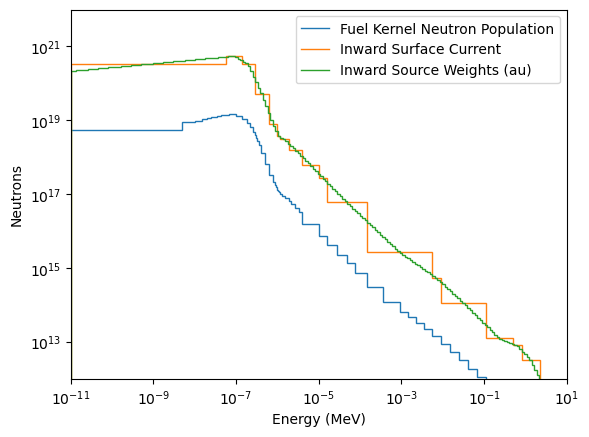

array([7.11944e+12, 1.56231e+13, 1.57962e+13, 6.66516e+12, 8.06496e+11,
       2.25965e+11, 6.10604e+11, 1.20058e+12, 1.15475e+12, 6.33688e+11,
       2.70627e+12, 5.06599e+12, 8.46274e+11, 3.34685e+12, 1.98527e+12,
       9.17178e+11, 1.94724e+12, 7.70486e+11])

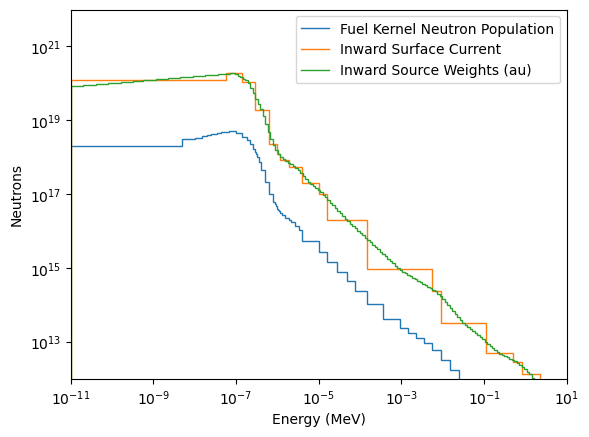

array([7.06158e+13, 1.56550e+14, 1.60655e+14, 8.35441e+13, 1.85250e+13,
       5.55950e+12, 1.48210e+13, 2.60878e+13, 2.57612e+13, 1.45071e+13,
       6.59658e+13, 1.15613e+14, 1.43661e+13, 7.26777e+13, 3.60389e+13,
       1.72222e+13, 2.88180e+13, 1.15943e+13])

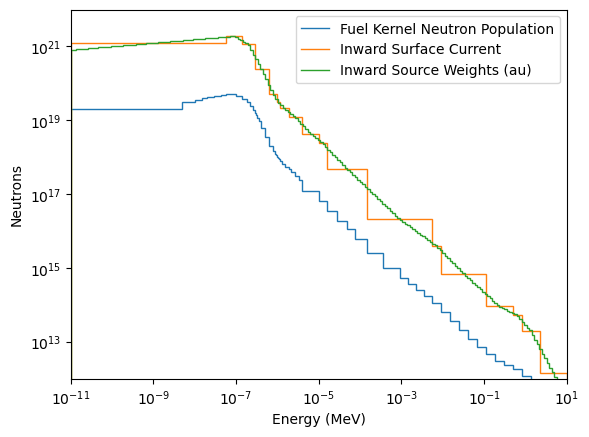

array([3.56025e+13, 7.85357e+13, 7.99011e+13, 3.56555e+13, 5.59769e+12,
       1.81318e+12, 4.90209e+12, 7.74119e+12, 8.14459e+12, 4.14366e+12,
       2.05714e+13, 3.88832e+13, 5.68790e+12, 2.76614e+13, 1.52165e+13,
       7.12898e+12, 1.12554e+13, 4.33847e+12])

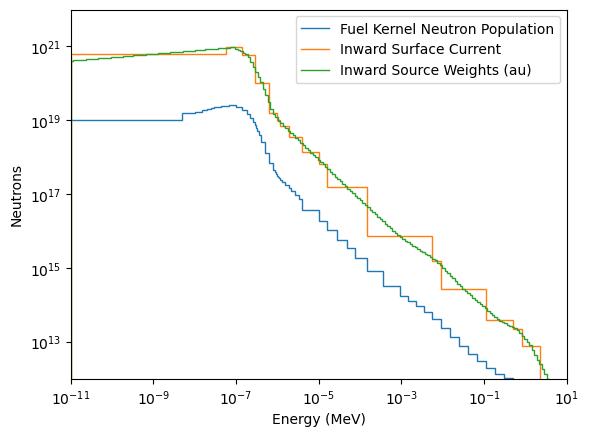

array([7.69780e+13, 1.92669e+14, 2.16396e+14, 1.53906e+14, 4.08467e+13,
       1.61843e+13, 4.02582e+13, 7.24386e+13, 7.46117e+13, 4.35862e+13,
       2.23619e+14, 3.91403e+14, 5.28041e+13, 2.71611e+14, 1.30187e+14,
       6.01730e+13, 1.12110e+14, 3.78448e+13])

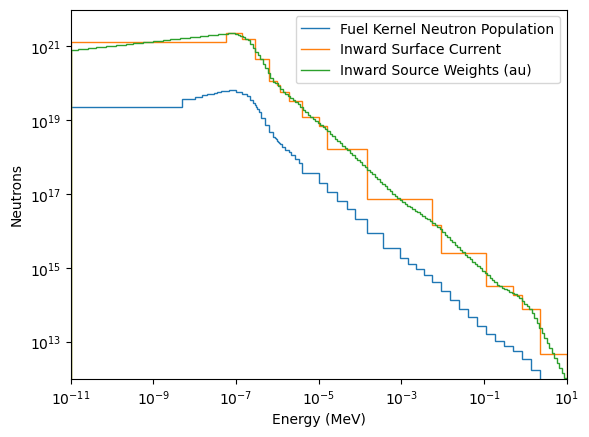

array([7.38950e+13, 1.68434e+14, 1.72225e+14, 8.03170e+13, 1.53615e+13,
       5.14135e+12, 1.40552e+13, 2.18160e+13, 2.27184e+13, 1.40249e+13,
       5.85327e+13, 1.01822e+14, 1.42547e+13, 6.97106e+13, 3.85578e+13,
       1.89599e+13, 3.46294e+13, 1.52903e+13])

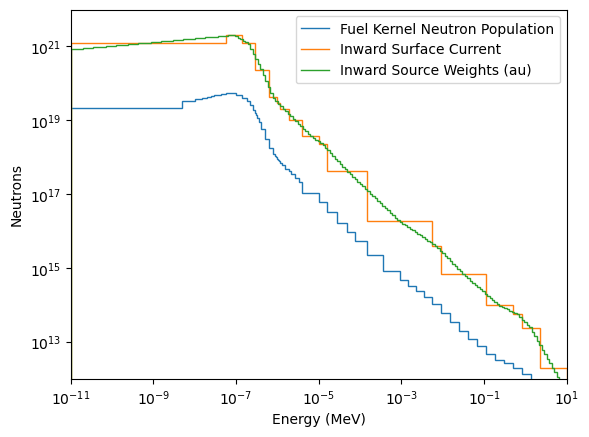

array([7.14152e+13, 1.76225e+14, 1.78542e+14, 1.18262e+14, 3.04138e+13,
       1.24683e+13, 3.11456e+13, 3.88908e+13, 5.81080e+13, 3.17562e+13,
       1.62895e+14, 2.91425e+14, 4.65660e+13, 2.19806e+14, 1.14621e+14,
       4.89915e+13, 9.68014e+13, 3.31494e+13])

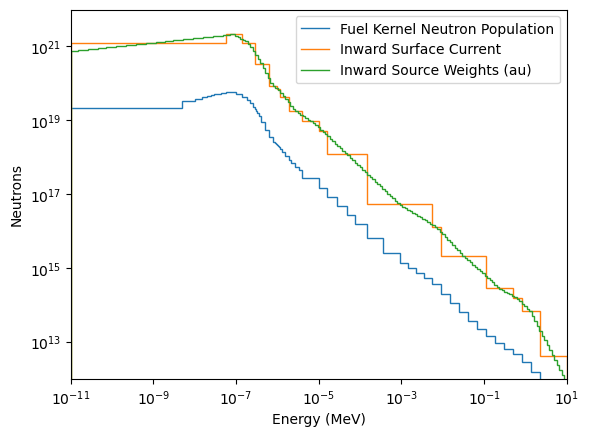

array([5.34836e+13, 1.31075e+14, 1.46444e+14, 9.27485e+13, 2.81970e+13,
       1.09086e+13, 2.41769e+13, 3.72853e+13, 4.94978e+13, 2.19766e+13,
       1.31002e+14, 2.22170e+14, 3.52308e+13, 1.62611e+14, 7.26149e+13,
       4.08989e+13, 6.23119e+13, 2.15153e+13])

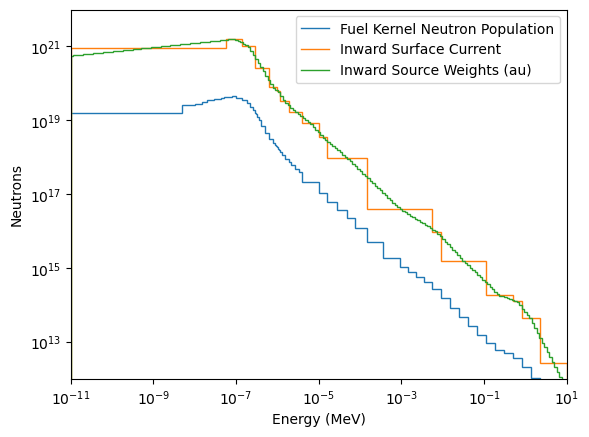

In [14]:
xs_frames = []
concentration_output = []
flux_array = []
input_frames = []
flux_spectra_arrays = []


for i in range(starting_iter,iterations+starting_iter):
    input_file_name = f"burnup_models/burnup{i}.serpent"
    conc_dict = extract_from_bumat(f"burnup_models/burnup{i}.serpent.bumat1")
    input_data = pd.read_csv(f"burnup_models/input_data_{i}.csv", index_col=0)
    concentration_output += [pd.DataFrame(conc_dict)]
    input_frames += [input_data]
    det_name = input_file_name+"_det0.m"
    flux, flux_unc = read_pebble_flux(det_name)
    flux_spectra_arrays += [flux]
    
    xs_name = f"burnup_models/burnup{i}.serpent_mdx0.m"
    xs_df, flux_val = extract_xs_from_mdx(xs_name)
    flux_array += [flux_val]
    xs_frames += [xs_df]



    if i % 25 == 0:
        input_current = input_data[current_indices].values[0]
        display(input_current)
        source_bins, source_weights = gen_source_distribution(input_current)

        plt.figure()
        plt.stairs(flux/energy_differences, energy_bins, label="Fuel Kernel Neutron Population")
        plt.stairs(input_current/current_bin_widths, ENERGY_BINS, label="Inward Surface Current")
        plt.stairs(source_weights[1:], source_bins, label="Inward Source Weights (au)")
        plt.legend()
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Energy (MeV)")
        plt.ylabel("Neutrons")
        plt.xlim(1e-11,10)
        plt.ylim(1E12,1E22)
        plt.show()

In [15]:
features_df = pd.concat(input_frames, sort=False).fillna(0.0).reset_index(drop=True)
display(features_df.iloc[0:5])
print(features_df.shape)

,1003<lib>,6012<lib>,60130,8016<lib>,34074<lib>,34080<lib>,34082<lib>,35081<lib>,36080<lib>,36082<lib>,...,current_E12,current_E13,current_E14,current_E15,current_E16,current_E17,current_E18,power,depletion_time,temperature
0,1.588984e-14,0.011691,0.000126,0.035463,1.247539e-14,4.080364e-06,1.032088e-05,6.574997e-06,1.474235e-11,1.474651e-07,...,1.918580e+15,2.767560e+14,1.337520e+15,6.751830e+14,2.986080e+14,5.010360e+14,1.946540e+14,1336.650,6.525,959.0
1,2.313322e-17,0.011691,0.000125,0.035463,1.333009e-17,1.774031e-07,4.467850e-07,2.803852e-07,2.015239e-13,1.353061e-10,...,8.995880e+13,1.326100e+13,6.275400e+13,3.220640e+13,1.420010e+13,2.883840e+13,1.073100e+13,390.635,6.525,959.0
2,5.551811e-20,0.011691,0.000125,0.035463,1.917643e-18,7.524731e-08,1.895287e-07,1.187727e-07,8.039342e-14,3.714896e-11,...,8.588680e+13,1.227590e+13,6.161790e+13,2.955530e+13,1.424780e+13,2.539830e+13,9.203530e+12,442.500,1.631,959.0
3,8.931976e-29,0.011691,0.000125,0.035463,8.752089e-19,3.919540e-08,9.872711e-08,6.186364e-08,4.149634e-14,1.714942e-11,...,3.546420e+13,5.487070e+12,2.473910e+13,1.387390e+13,6.009220e+12,1.228270e+13,4.632210e+12,240.646,6.525,959.0
4,1.791915e-18,0.011691,0.000125,0.035463,2.657320e-16,8.116525e-07,2.043483e-06,1.285849e-06,1.037548e-12,2.080222e-09,...,5.339200e+13,6.512510e+12,3.992860e+13,1.960020e+13,8.649960e+12,1.651240e+13,6.255910e+12,283.158,6.525,959.0


(200, 1333)


In [16]:
energy_group_labels = ["2.50000E-09", "7.50000E-09", "1.25000E-08", "1.75000E-08", "2.25000E-08", "2.75000E-08", "3.25000E-08", "3.85000E-08", "4.60000E-08", "5.40000E-08", "6.25000E-08", "7.35000E-08", "9.00000E-08", "1.20000E-07", "1.60000E-07", "2.00000E-07", "2.35000E-07", "2.65000E-07", "2.90000E-07", "3.10000E-07", "3.35000E-07", "3.75000E-07", "4.50000E-07", "5.62500E-07", "7.02500E-07", "8.15000E-07", "8.80000E-07", "9.30000E-07", "9.61000E-07", "9.84000E-07", "1.00800E-06", "1.03250E-06", "1.05800E-06", "1.08400E-06", "1.11000E-06", "1.13650E-06", "1.22500E-06", "1.40000E-06", "1.67750E-06", "1.97750E-06", "2.35000E-06", "2.95000E-06", "3.65000E-06", "6.93850E-06", "1.29225E-05", "2.18340E-05", "3.78760E-05", "6.17767E-05", "1.12115E-04", "2.57995E-04", "6.37080E-04", "1.16600E-03", "1.83227E-03", "2.87927E-03", "4.50955E-03", "7.30900E-03", "1.20740E-02", "1.99050E-02", "3.28150E-02", "5.41400E-02", "8.92150E-02", "1.47000E-01", "2.42750E-01", "4.01250E-01", "6.60500E-01", "1.08700E+00", "1.79200E+00", "2.95500E+00", "4.87225E+00", "5.00000E+36"]
flux_spectra_df = pd.DataFrame(flux_spectra_arrays, columns=energy_group_labels)
flux_spectra_df["total_pebble_flux"] = flux_array
display(flux_spectra_df.iloc[0:5])
print(flux_spectra_df.shape)

,2.50000E-09,7.50000E-09,1.25000E-08,1.75000E-08,2.25000E-08,2.75000E-08,3.25000E-08,3.85000E-08,4.60000E-08,5.40000E-08,...,1.47000E-01,2.42750E-01,4.01250E-01,6.60500E-01,1.08700E+00,1.79200E+00,2.95500E+00,4.87225E+00,5.00000E+36,total_pebble_flux
0,5.095980e+11,7.817140e+11,8.506140e+11,9.550200e+11,1.015120e+12,1.043990e+12,1.092850e+12,1.561800e+12,1.875540e+12,1.913320e+12,...,6.145600e+12,6.446900e+12,7.544280e+12,8.359570e+12,7.731550e+12,6.097980e+12,3.819860e+12,2.061220e+12,9.460030e+11,8.621130e+16
1,7.939600e+10,1.268420e+11,1.408100e+11,1.580860e+11,1.701370e+11,1.761820e+11,1.837730e+11,2.636840e+11,3.173770e+11,3.255040e+11,...,2.979330e+11,3.319670e+11,4.163210e+11,5.102800e+11,5.848730e+11,5.637180e+11,4.095200e+11,2.123600e+11,7.478940e+10,4.286270e+15
2,8.263500e+10,1.317260e+11,1.460110e+11,1.638170e+11,1.752720e+11,1.813670e+11,1.900930e+11,2.722260e+11,3.276520e+11,3.352810e+11,...,2.804760e+11,3.135640e+11,4.072320e+11,5.116300e+11,5.600050e+11,5.430820e+11,4.017500e+11,2.082250e+11,6.819920e+10,4.253300e+15
3,4.628270e+10,7.230610e+10,7.971620e+10,8.863710e+10,9.517560e+10,9.805200e+10,1.023920e+11,1.465600e+11,1.757240e+11,1.797150e+11,...,1.289470e+11,1.474520e+11,1.865460e+11,2.346290e+11,2.735700e+11,2.763520e+11,2.075880e+11,1.079030e+11,3.615490e+10,1.802040e+15
4,6.299110e+10,9.822820e+10,1.079240e+11,1.204940e+11,1.292560e+11,1.331310e+11,1.387830e+11,1.990910e+11,2.386870e+11,2.440850e+11,...,1.873720e+11,2.072740e+11,2.604950e+11,3.215290e+11,3.607780e+11,3.535790e+11,2.632120e+11,1.375350e+11,4.584610e+10,2.462040e+15


(200, 71)


In [17]:
post_burn_conc_df = pd.concat(concentration_output, sort=False).fillna(0.0).reset_index(drop=True)
display(post_burn_conc_df.iloc[0:5])
print(post_burn_conc_df.shape)

,10010,10020,1003<lib>,20030,20040,40090,50110,50120,6012<lib>,60130,...,531220,551280,481040,491101,501100,541220,621420,430940,571340,862160
0,9.465268e-10,9.436275e-11,1.695195e-14,2.302246e-15,7.261703e-07,1.466388e-08,2.912315e-14,1.602450e-21,0.011691,0.000126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.635691e-11,7.361993e-13,4.808605e-17,1.389541e-18,8.433346e-09,4.705992e-10,5.811842e-15,2.322536e-22,0.011691,0.000125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.762000e-13,5.575177e-14,7.771446e-18,7.396430e-21,2.206188e-09,2.434211e-10,2.559732e-15,3.913864e-22,0.011691,0.000125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.046592e-12,1.149547e-13,2.592328e-17,2.130614e-20,1.196716e-09,4.021808e-11,5.053168e-15,1.721720e-22,0.011691,0.000125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.133200e-12,1.981594e-13,5.204322e-17,1.009764e-18,2.491595e-08,4.911612e-10,3.629440e-15,1.326318e-22,0.011691,0.000125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(200, 1322)


In [18]:
xs_rows = []
for i in range(starting_iter, starting_iter+iterations):
    frame = xs_frames[i-1]
    frame["reaction_id"] = frame[["isotope","mt","flag"]].astype(str).agg('-'.join, axis=1)
    frame = frame.set_index("reaction_id").drop(columns=["xs_unc","mt","flag","isotope"]).T
    xs_rows += [frame]
xs_df = pd.concat(xs_rows, sort=False).fillna(0.0).reset_index(drop=True)
xs_df = xs_df.loc[:, (xs_df != 0).any(axis=0)]
display(xs_df.iloc[0:5])
print(xs_df.shape)

reaction_id,10030-16-0,60120-102-0,60120-103-0,60120-107-0,80160-16-0,80160-102-0,80160-103-0,80160-107-0,340740-16-0,340740-102-0,...,962490-16-0,962490-17-0,962490-18-1,962490-102-0,962500-16-0,962500-17-0,962500-18-1,962500-102-0,962500-18-3,962500-18-2
0,2.227620e-08,6.200750e-07,5.919920e-11,0.000002,1.504210e-14,3.151560e-08,4.691630e-09,0.000007,8.847440e-09,0.230994,...,0.000016,1.638290e-09,0.051779,0.023426,0.000004,9.488890e-09,0.000035,0.124673,0.000183,0.001131
1,3.290960e-08,6.891490e-07,2.097660e-10,0.000003,4.204440e-12,3.456860e-08,2.313130e-08,0.000012,3.327730e-08,0.203606,...,0.000027,6.266240e-09,0.047565,0.020551,0.000006,3.947770e-08,0.000032,0.111969,0.000347,0.002027
2,3.168710e-08,7.314250e-07,3.052960e-10,0.000003,8.620530e-12,3.699870e-08,2.614510e-08,0.000012,4.204020e-08,0.229704,...,0.000025,7.689630e-09,0.050428,0.022222,0.000006,4.516190e-08,0.000034,0.122559,0.000336,0.001977
3,3.876570e-08,6.908850e-07,1.229610e-10,0.000003,9.464220e-12,3.437290e-08,3.424460e-08,0.000014,2.899910e-08,0.208407,...,0.000031,6.124180e-09,0.048562,0.020937,0.000007,4.832210e-08,0.000033,0.113789,0.000409,0.002359
4,3.702780e-08,6.448320e-07,2.556490e-10,0.000003,9.662500e-12,3.184800e-08,3.070650e-08,0.000013,4.228470e-08,0.196415,...,0.000029,7.982210e-09,0.046648,0.020061,0.000006,5.164100e-08,0.000029,0.097247,0.000382,0.002225


(200, 964)


In [19]:
features_df.to_csv("training_data/burnup_features.csv")
xs_df.to_csv("training_data/burnup_xs.csv")
flux_spectra_df.to_csv("training_data/burnup_flux.csv")
post_burn_conc_df.to_csv("training_data/burnup_final_concentrations.csv")

NameError: name 'chain' is not defined